In [ ]:
# Author: Elahe Golrokh
# Repo: https://github.com/ElahehGolrokh/TMDB-5000-Movie-Dataset.git
# TODO: CONSIDER THE EFFECT OF DIRECTOR AND OTHER CREW

# **1- Importing Libararies**

In [ ]:
# !pip install fuzzywuzzy -q

In [ ]:
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()
%matplotlib inline

In [ ]:
import matplotlib as mpl
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
# from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
from IPython.core.interactiveshell import InteractiveShell


# **2- Loading Data**

In [ ]:
from google.colab import drive
drive.mount('drive/')

Mounted at drive/


In [ ]:
data_path = '/content/drive/MyDrive/archive.zip'

In [ ]:
!unzip -q $data_path

# **3- Feature Engineering**
The TMDb data includes several json fields, so loading the data requires an extra step beyond reading the csv files. <br>
To convert the TMDb data to be as close as possible to the old format , copy the entire cell below into your kernel and run convert_to_original_format. Please note that the conversion isn't completely 1:1. <br>
First, we define a few functions to create an interface with the new structure of the dataset. The code below is entirely taken from [Sohier's](https://www.kaggle.com/code/sohier/getting-imdb-kernels-working-with-tmdb-data) kernel:

In [ ]:
#___________________________
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries',
                    'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________________
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________
# Columns that existed in the IMDB version of the dataset and are gone.
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']
#____________________________________
# Columns in TMDb that had direct equivalents in the IMDB version.
# These columns can be used with old kernels just by changing the names
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}
#_____________________________________________________
IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}
#_____________________________________________________
def safe_access(container, index_values):
    """return missing value rather than an error upon indexing/key failure"""
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan
#_____________________________________________________
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])
#_____________________________________________________
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])
#_____________________________________________________
def convert_to_original_format(movies, credits):
    """
    Converts TMDb data to make it as compatible as possible with kernels
    built on the original version of the data
    """
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    tmdb_movies['production_companies'] = tmdb_movies['production_companies'].apply(pipe_flatten_names)
    tmdb_movies['production_countries'] = tmdb_movies['production_countries'].apply(pipe_flatten_names)
    return tmdb_movies

In [ ]:
# plt.rcParams["patch.force_edgecolor"] = True
# plt.style.use('fivethirtyeight')
# mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
# InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()
#__________________
# load the dataset
credits = load_tmdb_credits("/content/tmdb_5000_credits.csv")
movies = load_tmdb_movies("/content/tmdb_5000_movies.csv")
df_initial = convert_to_original_format(movies, credits)
print('Shape:',df_initial.shape)
#__________________________________________
# info on variable types and filling factor
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info.T

Shape: (4803, 26)


,column type,null values,null values (%)
budget,int64,0,0.0
genres,object,0,0.0
homepage,object,3091,64.355611
id,int64,0,0.0
plot_keywords,object,0,0.0
language,object,86,1.790548
original_title,object,0,0.0
overview,object,3,0.062461
popularity,float64,0,0.0
production_companies,object,0,0.0


In [ ]:
df_initial.shape

(4803, 26)

# **4- Data Cleaning**

## **Dealing with nans and not informative categories**

In [ ]:
df_initial.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
plot_keywords              0
language                  86
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
gross                      0
duration                   2
spoken_languages           0
status                     0
tagline                  844
movie_title                0
vote_average               0
num_voted_users            0
title_year                 1
country                  174
director_name             30
actor_1_name              53
actor_2_name              63
actor_3_name              93
dtype: int64

In [ ]:
df_initial.head(1)

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,Ingenious Film Partners|Twentieth Century Fox ...,United States of America|United Kingdom,2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang


In [ ]:
df_initial.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
budget,4803.0,NaN,NaN,NaN,29045039.875286,40722391.25855,0.0,790000.0,15000000.0,40000000.0,380000000.0
genres,4803,1175,Drama,370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
homepage,1712,1691,http://www.missionimpossible.com/,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,4803.0,NaN,NaN,NaN,57165.484281,88694.614033,5.0,9014.5,14629.0,58610.5,459488.0
plot_keywords,4803,4222,,412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
language,4717,47,English,4102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_title,4803,4801,Out of the Blue,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
overview,4800,4800,"In the 22nd century, a paraplegic Marine is di...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
popularity,4803.0,NaN,NaN,NaN,21.492301,31.81665,0.0,4.66807,12.921594,28.313505,875.581305
production_companies,4803,3697,,351,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_remove_nan = df_initial.copy()
df_remove_nan['release_date'] = pd.to_datetime(df_remove_nan['release_date'])
# df_remove_nan['release_year'] = df_remove_nan['release_date'].apply(lambda x: x.year)
df_remove_nan['release_month'] = df_remove_nan['release_date'].apply(lambda x: x.month)
df_remove_nan.drop(['tagline', 'homepage', 'overview', 'status', 'original_title',
                    'title_year', 'release_date', 'id', 'production_countries'], axis=1, inplace=True)
df_remove_nan.dropna(inplace=True)
df_remove_nan.isnull().sum()

budget                  0
genres                  0
plot_keywords           0
language                0
popularity              0
production_companies    0
gross                   0
duration                0
spoken_languages        0
movie_title             0
vote_average            0
num_voted_users         0
country                 0
director_name           0
actor_1_name            0
actor_2_name            0
actor_3_name            0
release_month           0
dtype: int64

In [ ]:
df_remove_nan.shape

(4548, 18)

## **Removing outliers**

In [ ]:
def remove_outliers(df, col, perc):
  q = df[col].quantile(perc)
  if perc > .5:
    df = df[df[col] < q]
  else:
    df = df[df[col] > q]
  return df

In [ ]:
numerical_columns = ['budget', 'popularity', 'gross',
                     'duration', 'vote_average', 'num_voted_users']
categorical_columns = ['genres', 'plot_keywords', 'language', 'production_companies',
                       'spoken_languages', 'country', 'release_month']

col = budget


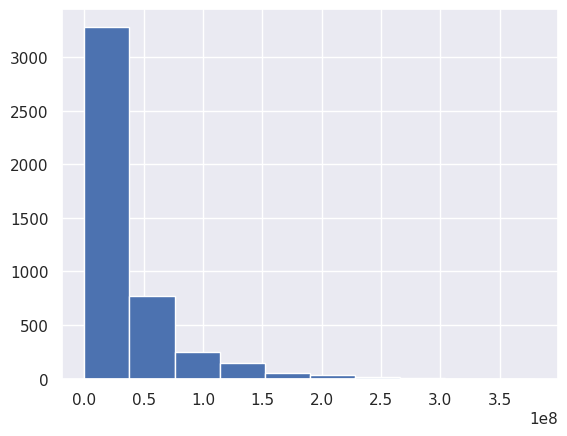

__________________________________________________________________________
col = popularity


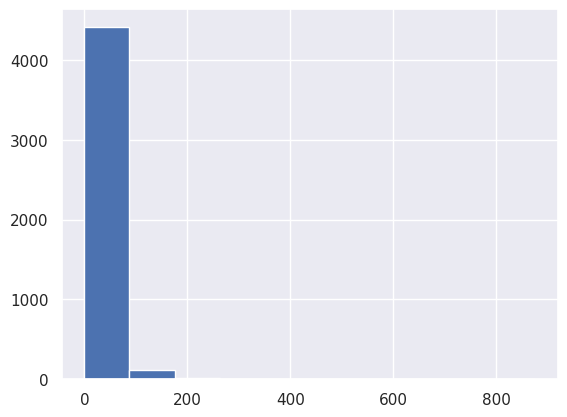

__________________________________________________________________________
col = gross


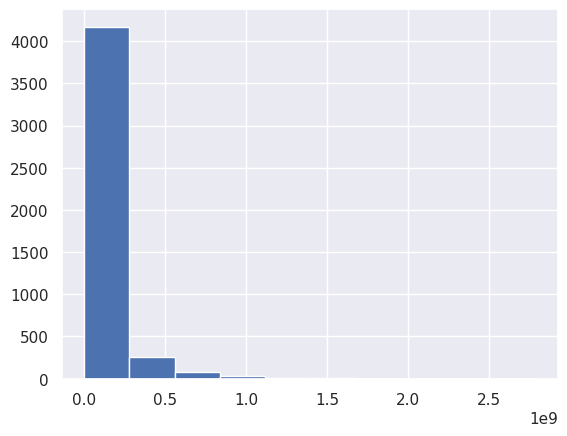

__________________________________________________________________________
col = duration


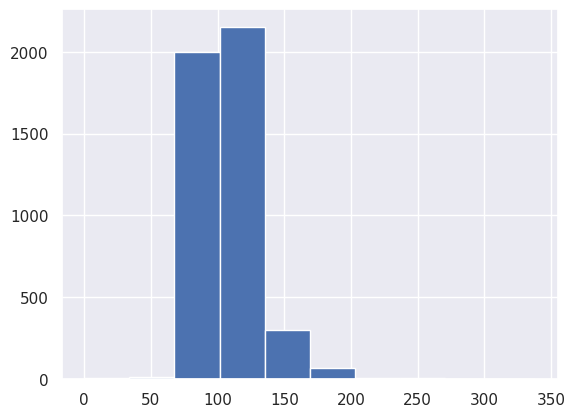

__________________________________________________________________________
col = vote_average


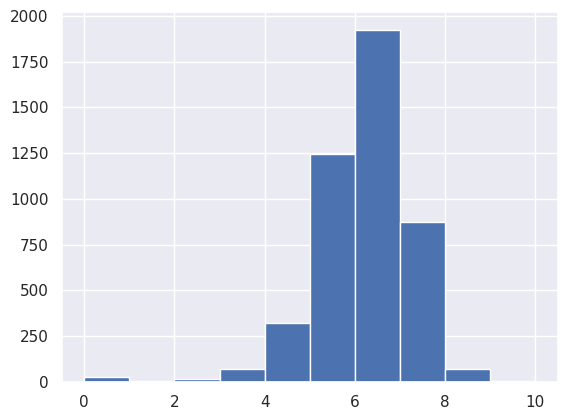

__________________________________________________________________________
col = num_voted_users


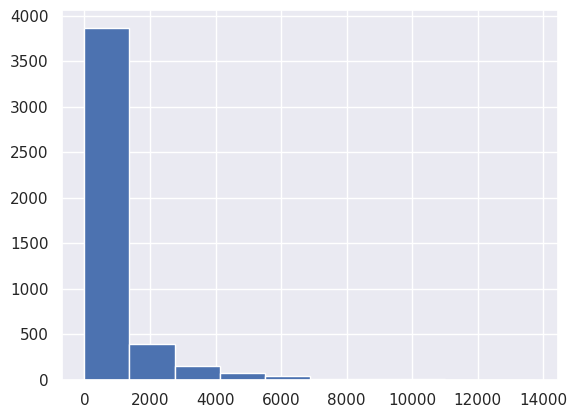

__________________________________________________________________________


In [ ]:
for col in numerical_columns:
  print(f'col = {col}')
  plt.hist(df_remove_nan[col])
  plt.show()
  print('__________________________________________________________________________')

So it seems that all numerical columns contain outliers and we have to remove them.

In [ ]:
df_remove_outliers = df_remove_nan.copy()
print(f'df shape before removing outliers: {df_remove_outliers.shape}')
for col in numerical_columns:
  if col == 'vote_average':
    df_remove_outliers = remove_outliers(df_remove_outliers, col, .01)
  else:
    df_remove_outliers = remove_outliers(df_remove_outliers, col, .99)
print(f'df shape after removing outliers: {df_remove_outliers.shape}')


df shape before removing outliers: (4548, 18)
df shape after removing outliers: (4270, 18)


## **Dealing with categorical columns**

<Axes: >

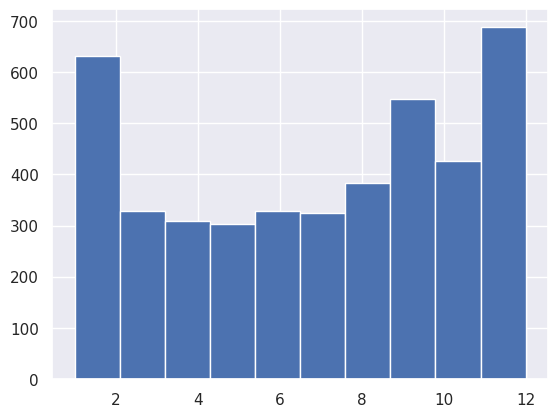

In [ ]:
df_categorical = df_remove_outliers.copy()
df_categorical['release_month'].hist()

So we can consider month as a categorical feature. Since the mean or median of it means nothing. Based on the histogram we consider two categories; first half months and second half months.

<Axes: xlabel='release_month', ylabel='count'>

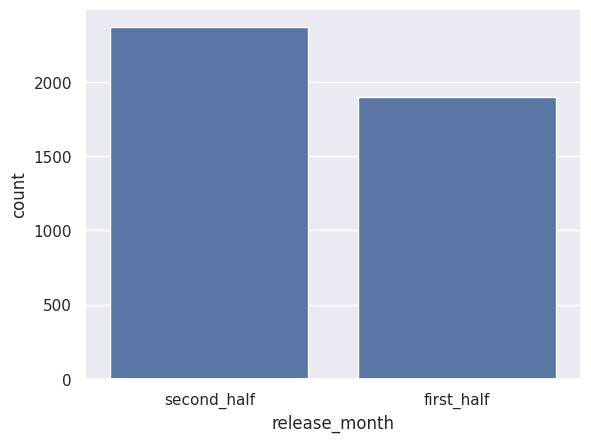

In [ ]:
df_categorical['release_month'] = df_categorical['release_month'].apply(lambda x: 'first_half' if x <= 6 else 'second_half')
sns.countplot(data=df_categorical, x='release_month')

<Axes: xlabel='count', ylabel='country'>

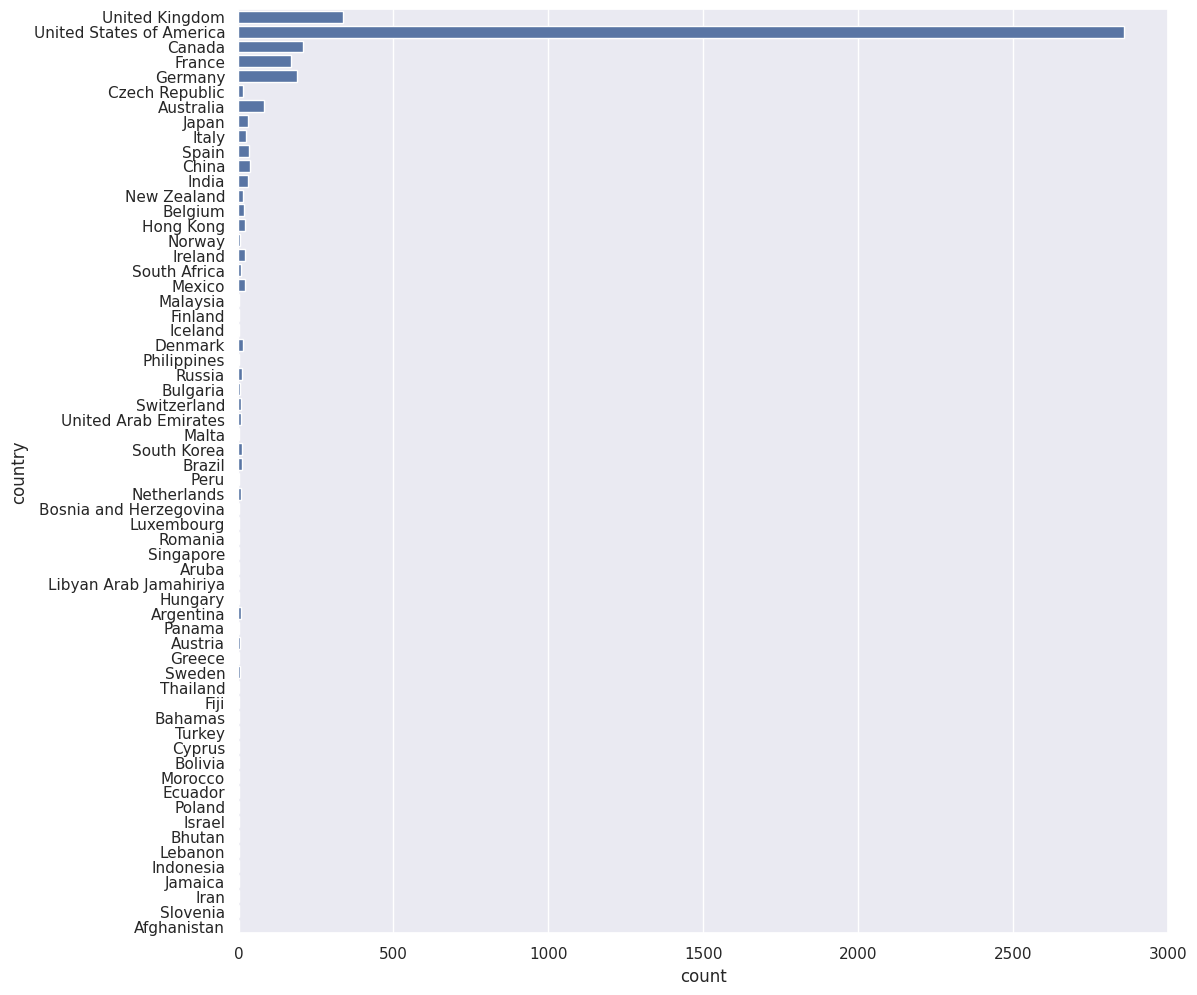

In [ ]:
plt.figure(figsize=(12, 12))
sns.countplot(df_categorical['country'])

So we can split the country column into two categories; USA and Not USA!:)
For EDA phase we use the original form of this column but later for modeling we apply this consideration.

<Axes: xlabel='count', ylabel='language'>

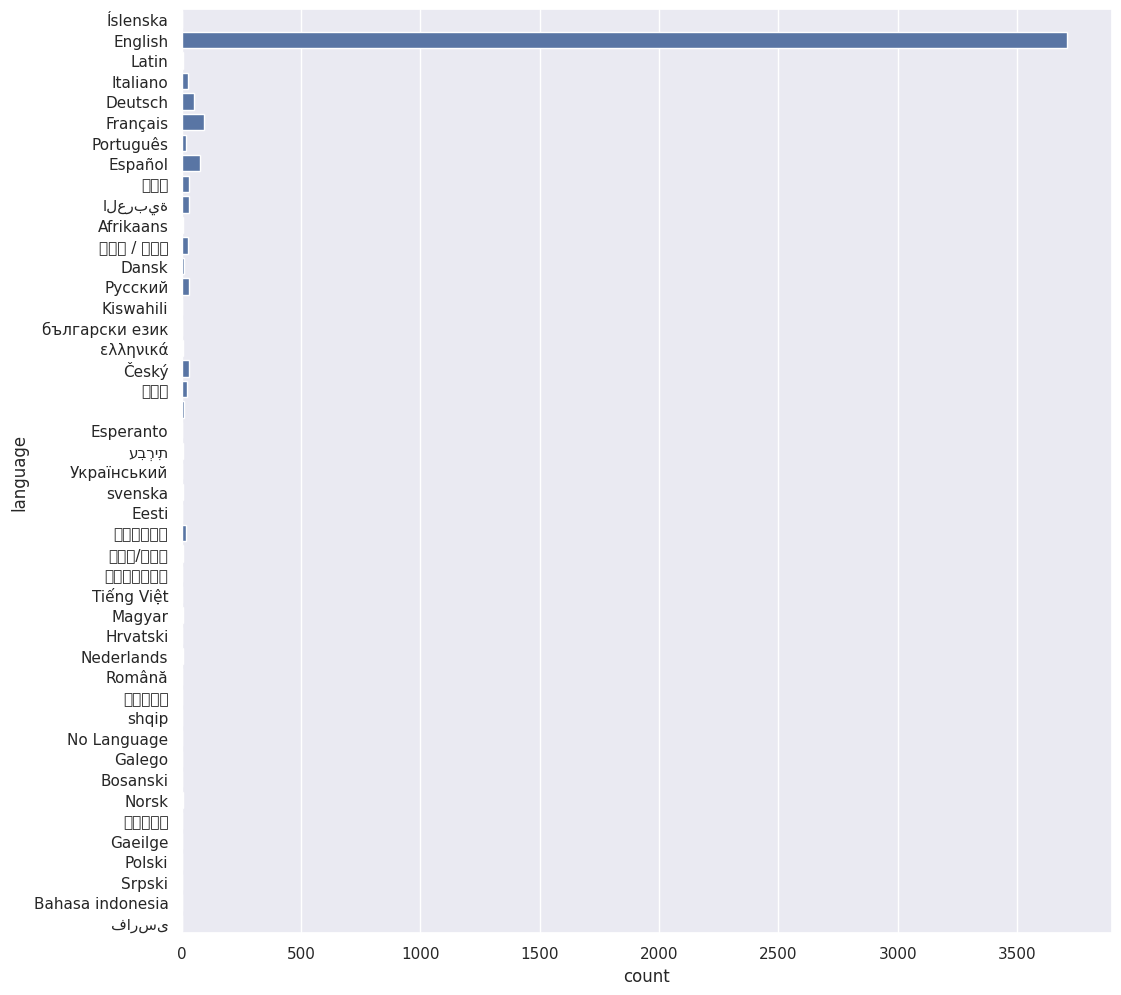

In [ ]:
plt.figure(figsize=(12, 12))
sns.countplot(df_categorical['language'])

So the movie language is highly imbalanced and can not be considered as a predictive feature.

In [ ]:
df_categorical.drop(['spoken_languages', 'language'], axis=1, inplace=True)

### **categorical columns with multi-categories; genres, keywords and companies**

In [ ]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in [s for s in liste_keywords if s in liste]:
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [ ]:
df_categorical_multi_ = df_categorical.copy()

In [ ]:
df_categorical_multi_.head(1)

,budget,genres,plot_keywords,popularity,production_companies,gross,duration,movie_title,vote_average,num_voted_users,country,director_name,actor_1_name,actor_2_name,actor_3_name,release_month
23,180000000,Adventure|Fantasy,england|compass|experiment|lordship|uncle|pola...,42.990906,New Line Cinema|Ingenious Film Partners|Depth ...,372234864,113.0,The Golden Compass,5.8,1303,United Kingdom,Chris Weitz,Nicole Kidman,Daniel Craig,Sam Elliott,second_half


In [ ]:
set_keywords = set()
for liste_keywords in df_categorical_multi_['production_companies'].str.split('|').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)
#_________________________
# remove null chain entry
# set_keywords.remove('')
keyword_occurences, dum = count_word(df_categorical_multi_, 'production_companies', set_keywords)
keyword_occurences

[['Universal Pictures', 289],
 ['Warner Bros.', 279],
 ['Paramount Pictures', 262],
 ['Twentieth Century Fox Film Corporation', 201],
 ['Columbia Pictures', 185],
 ['', 161],
 ['New Line Cinema', 156],
 ['Touchstone Pictures', 117],
 ['Metro-Goldwyn-Mayer (MGM)', 116],
 ['Relativity Media', 100],
 ['Columbia Pictures Corporation', 95],
 ['Miramax Films', 92],
 ['Walt Disney Pictures', 89],
 ['Village Roadshow Pictures', 75],
 ['DreamWorks SKG', 72],
 ['Canal+', 72],
 ['United Artists', 71],
 ['Regency Enterprises', 66],
 ['Fox Searchlight Pictures', 63],
 ['TriStar Pictures', 55],
 ['Dimension Films', 53],
 ['Fox 2000 Pictures', 53],
 ['Working Title Films', 53],
 ['Dune Entertainment', 51],
 ['Lionsgate', 51],
 ['Summit Entertainment', 46],
 ['StudioCanal', 41],
 ['The Weinstein Company', 39],
 ['Screen Gems', 39],
 ['Amblin Entertainment', 39],
 ['BBC Films', 38],
 ['Castle Rock Entertainment', 37],
 ['New Regency Pictures', 37],
 ['Focus Features', 36],
 ['UK Film Council', 36],
 ['

In [ ]:
keywords = set()
for s in df_categorical_multi_['plot_keywords'].values:
  if not pd.isnull(s):
    s = s.split('|')
    keywords = keywords.union(set(s))
len(keywords)

9356

So production company and related keywords can not be considered as predictive features. we can only use it for the EDA phase. but finnaly for modeling phase we have to remove it.

In [ ]:
set_keywords = set()
for liste_keywords in df_categorical_multi_['genres'].str.split('|').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)
#_________________________
# remove null chain entry
# set_keywords.remove('')
keyword_occurences, dum = count_word(df_categorical_multi_, 'genres', set_keywords)
keyword_occurences

[['Drama', 2086],
 ['Comedy', 1594],
 ['Thriller', 1199],
 ['Action', 1009],
 ['Romance', 835],
 ['Crime', 656],
 ['Adventure', 655],
 ['Horror', 490],
 ['Science Fiction', 447],
 ['Family', 436],
 ['Fantasy', 367],
 ['Mystery', 325],
 ['Animation', 192],
 ['Music', 176],
 ['History', 172],
 ['War', 124],
 ['Western', 71],
 ['Documentary', 65],
 ['Foreign', 22],
 ['TV Movie', 7],
 ['', 2]]

In [ ]:
df_categorical_multi_['genres'] = df_categorical_multi_['genres'].apply(lambda x: np.nan if x=='' else x)
df_categorical_multi_['genres'].isnull().sum()

2

In [ ]:
df_categorical_multi_.dropna(subset=["genres"], inplace=True)

In [ ]:
def generate_categorical_columns(df: pd.DataFrame,
                                 ref_col: str,
                                 col_name: str,
                                 keyword: str) -> pd.DataFrame:
  """
  Generates new categorical columns for each distinct categories
  in a complex column like genre in which there are plenty of
  categories dixtinguished by | or some other signs
  """
  df[col_name] = df[ref_col].apply(lambda x: 1 if keyword in x else 0)
  return df

In [ ]:
for genre in keyword_occurences:
  genre_labels = genre[0]
  occurances = genre[1]
  if occurances > 500:
    col_name = 'genre_' + genre_labels.replace(' ', '_')
    df_categorical_multi_ = generate_categorical_columns(df=df_categorical_multi_,
                                          ref_col='genres',
                                          col_name=col_name,
                                          keyword=genre_labels)
df_categorical_multi_.drop('genres', axis=1, inplace=True)
df_cleaned = df_categorical_multi_.copy()
df_cleaned.shape

(4268, 22)

# **5- EDA**

In [ ]:
df_cleaned['decade'] = df_cleaned['title_year'].apply(lambda x:((x-1900)//10)*10)
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(gr):
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}
#______________________________________________________________
# Creation of a dataframe with statitical infos on each decade:
test = df_cleaned['title_year'].groupby(df_cleaned['decade']).apply(get_stats).unstack()

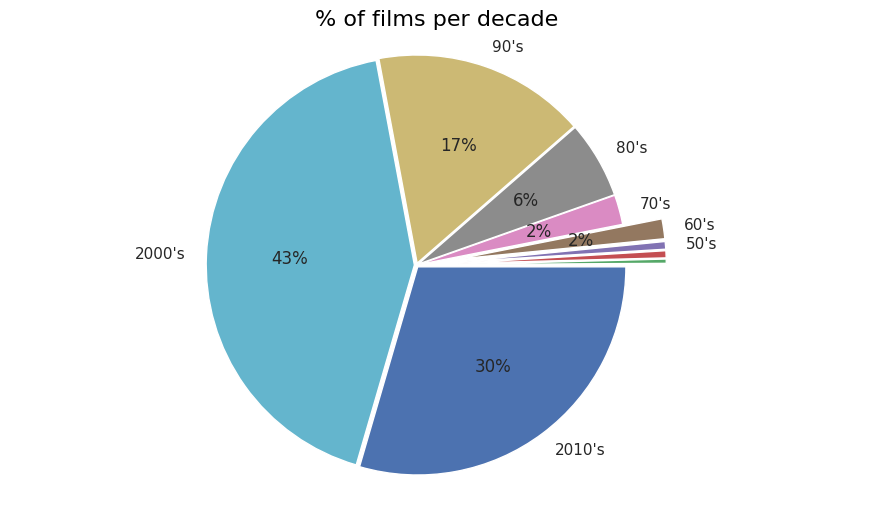

In [ ]:
sns.set_context(None, font_scale=0.85)
#_______________________________
# funtion used to set the labels
def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine
#____________________________________
plt.rc('font', weight='normal')
f, ax = plt.subplots(figsize=(11, 6))
labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(11)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% of films per decade',
             color='black', fontsize=16);
df_cleaned.drop('decade', axis=1, inplace = True)

## 5-2- Movie Analysis

<Axes: >

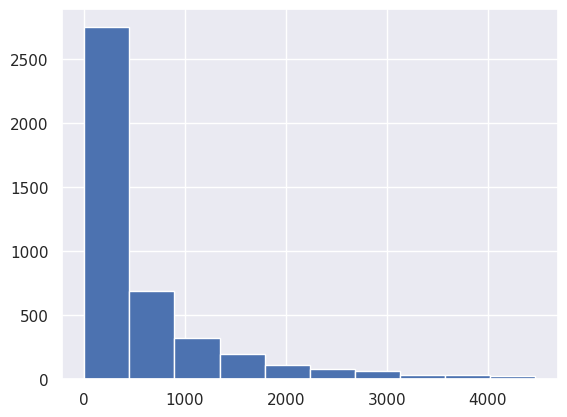

In [ ]:
df_cleaned['num_voted_users'].hist()

Text(0.5, 1.0, 'Popular Movies IN Terms of Averaged Vote')

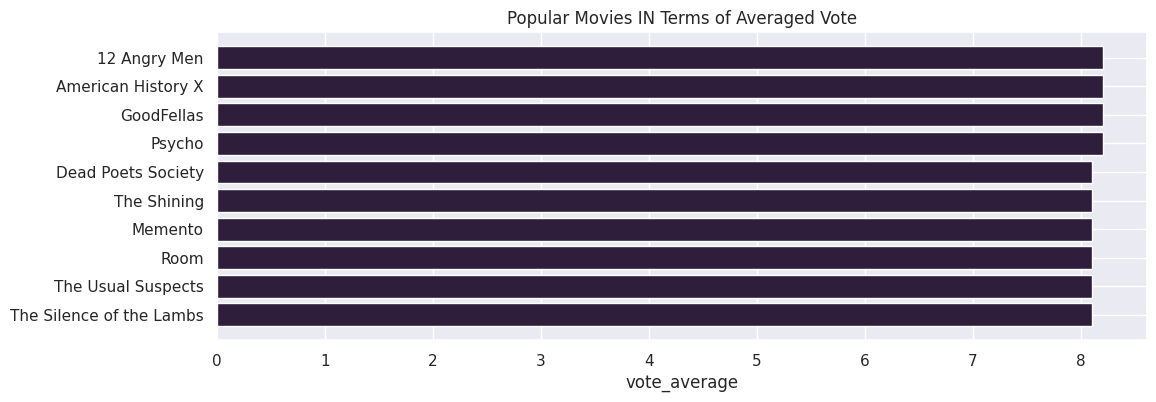

In [ ]:
most_watched_movies = df_cleaned[df_cleaned['num_voted_users']>2000]
pop = most_watched_movies.sort_values('vote_average', ascending=False)
sns.set_palette("mako")
plt.figure(figsize=(12,4))
plt.barh(pop['movie_title'].head(10),pop['vote_average'].head(10), align='center')
plt.gca().invert_yaxis()
plt.xlabel("vote_average")
plt.title("Popular Movies IN Terms of Averaged Vote")

Text(0.5, 1.0, 'Popular Movies IN Terms of Popularity')

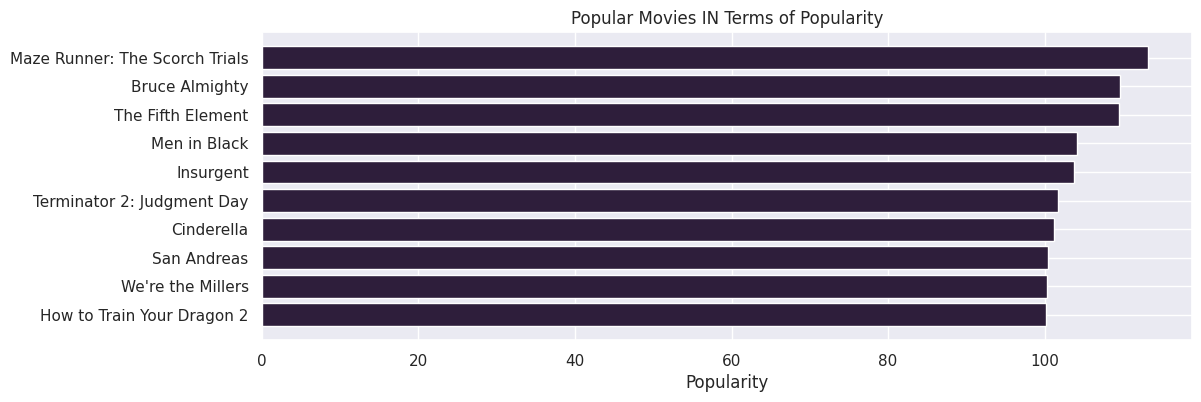

In [ ]:
pop = most_watched_movies.sort_values('popularity', ascending=False)
sns.set_palette("mako")
plt.figure(figsize=(12,4))
plt.barh(pop['movie_title'].head(10),pop['popularity'].head(10), align='center')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies IN Terms of Popularity")

In [ ]:
def categorical_vote_average(el):
  if el >= 8:
    vote_average = 'Best movies'
  elif el >= 6 and el < 8:
    vote_average = 'Good movies'
  elif el >= 4.5 and el < 6:
    vote_average = 'Bad movies'
  else:
    vote_average = 'Worst movies'
  return vote_average
most_watched_movies['categorical_vote_average'] = most_watched_movies['vote_average'].apply(categorical_vote_average)

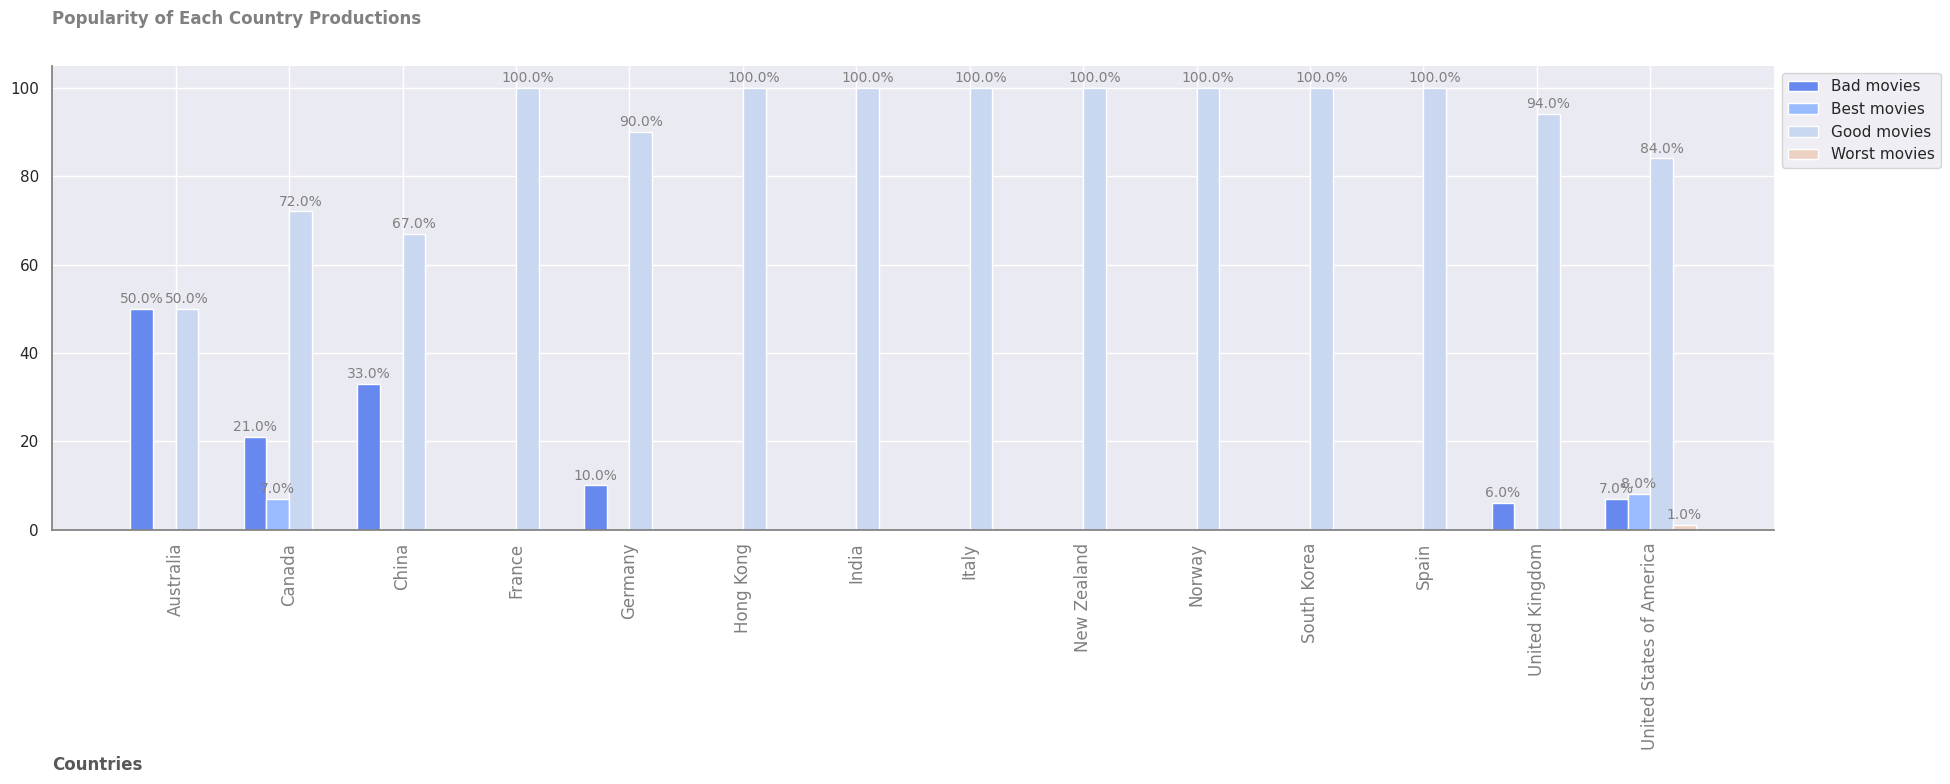

[<BarContainer object of 14 artists>,
 <BarContainer object of 14 artists>,
 <BarContainer object of 14 artists>,
 <BarContainer object of 14 artists>]

In [ ]:
sns.set_palette('coolwarm')
plot_grouped_barplot(df=most_watched_movies,
                     cols=['country', 'categorical_vote_average'],
                     x_label='Countries',
                     title='Popularity of Each Country Productions',
                     width=0.8,
                     annotate="values",
                     figsize=(18, 8),
                     rotation_angle=90)

In [ ]:
most_watched_movies.head(1)

,budget,plot_keywords,popularity,production_companies,gross,duration,movie_title,vote_average,num_voted_users,country,director_name,actor_1_name,actor_2_name,actor_3_name,release_month,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,categorical_vote_average
39,170000000,artificial intelligence|secret identity|comput...,73.79505,Walt Disney Pictures|LivePlanet|Prana Studios|...,400062763,125.0,TRON: Legacy,6.3,2841,United States of America,Joseph Kosinski,Jeff Bridges,Olivia Wilde,Bruce Boxleitner,second_half,0,0,0,1,0,0,1,Good movies


In [ ]:
higher_num_productions['country']

0                    Australia
1                       Canada
2                        China
3                       France
4                      Germany
6                        India
7                        Italy
12              United Kingdom
13    United States of America
Name: country, dtype: object

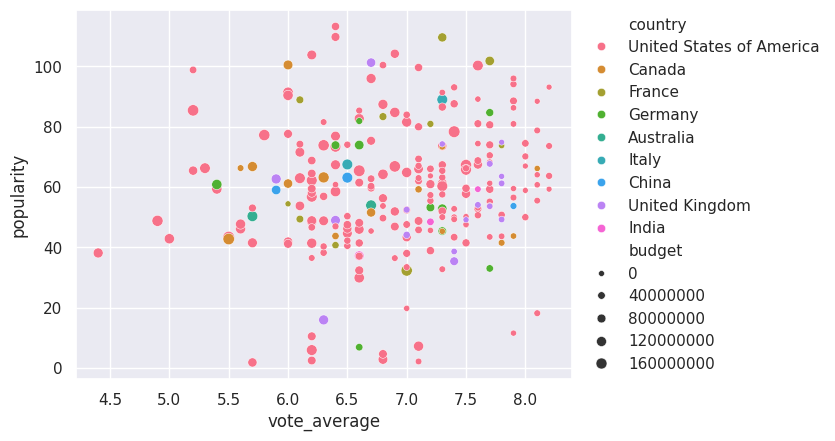

In [ ]:
sns.set_palette('mako')
higher_num_productions = most_watched_movies.groupby(['country'], as_index=False)['movie_title'].count()
higher_num_productions = higher_num_productions[higher_num_productions['movie_title']>1]
ax = sns.scatterplot(data=most_watched_movies[np.isin(most_watched_movies['country'], higher_num_productions['country'])], x='vote_average', y='popularity', hue='country', size='budget')
sns.move_legend(ax, bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)

Text(0.5, 1.0, 'The mean budget which each country have spent for the most popular movies')

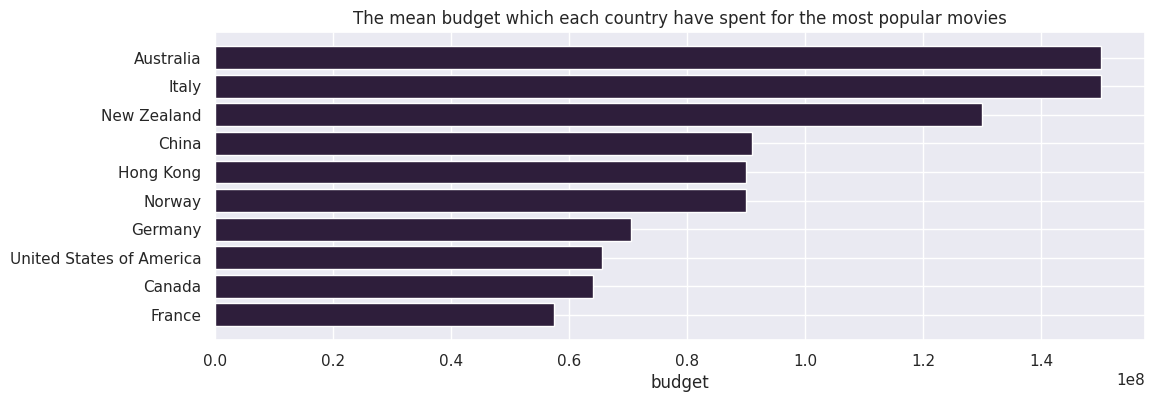

In [ ]:
pop = most_watched_movies.groupby(['country'], as_index=False)['budget'] \
                         .mean() \
                         .sort_values('budget', ascending=False)
sns.set_palette("mako")
plt.figure(figsize=(12,4))
plt.barh(pop['country'].head(10),pop['budget'].head(10), align='center')
plt.gca().invert_yaxis()
plt.xlabel("budget")
plt.title("The mean budget which each country have spent for the most popular movies")

Text(0.5, 1.0, 'The mean vote_average for the best movies of each country')

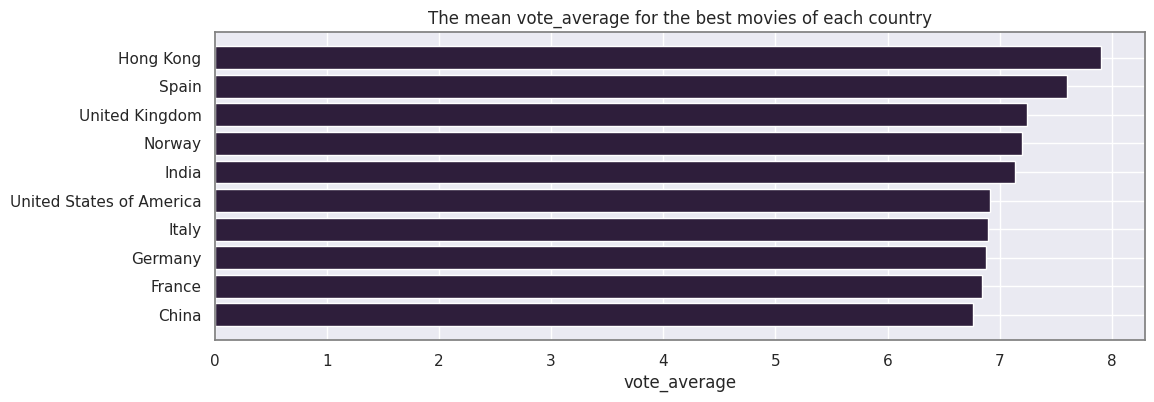

In [ ]:
pop = most_watched_movies.groupby(['country'], as_index=False)['vote_average'] \
                         .mean() \
                         .sort_values('vote_average', ascending=False)
sns.set_palette("mako")
plt.figure(figsize=(12,4))
plt.barh(pop['country'].head(10),pop['vote_average'].head(10), align='center')
plt.gca().invert_yaxis()
plt.xlabel("vote_average")
plt.title("The mean vote_average for the best movies of each country")

In [ ]:
most_watched_movies.groupby(['country'])['vote_average'].mean().sort_values(ascending=True)

country
Australia                   6.200000
Canada                      6.692857
New Zealand                 6.700000
South Korea                 6.700000
China                       6.766667
France                      6.840000
Germany                     6.880000
Italy                       6.900000
United States of America    6.917021
India                       7.133333
Norway                      7.200000
United Kingdom              7.241176
Spain                       7.600000
Hong Kong                   7.900000
Name: vote_average, dtype: float64

In [ ]:
order = most_watched_movies.groupby(['country'])['vote_average'].mean().sort_values(ascending=True).index

Text(0.5, 1.0, 'The mean vote_average for the best movies of each country')

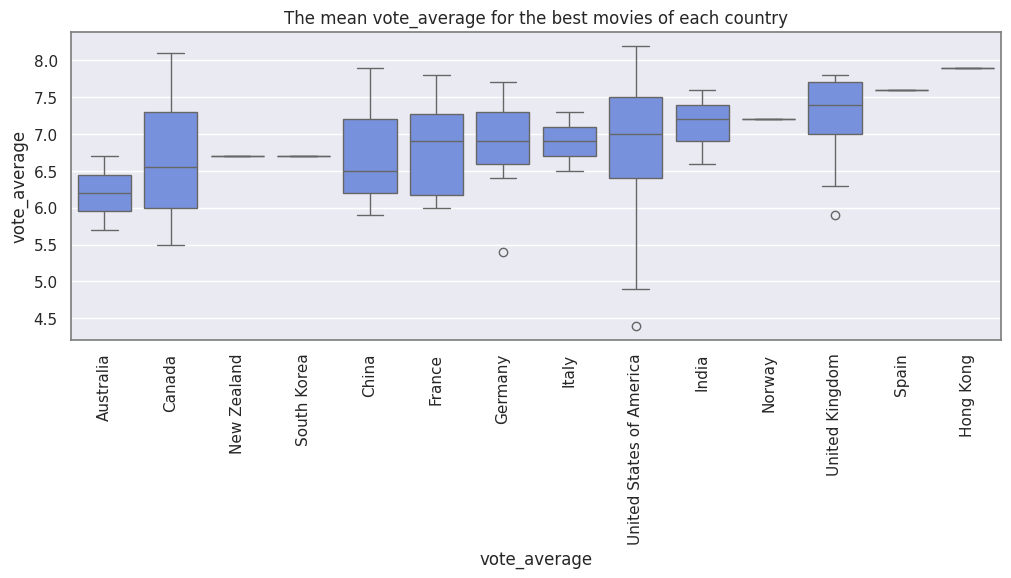

In [ ]:
sns.set_palette("coolwarm")
plt.figure(figsize=(12,4))
sns.boxplot(data=most_watched_movies, x='country', y='vote_average', order=order)
plt.xticks(rotation=90)
plt.xlabel("vote_average")
plt.title("The mean vote_average for the best movies of each country")

Text(0.5, 1.0, 'The mean budget for the best movies of each country')

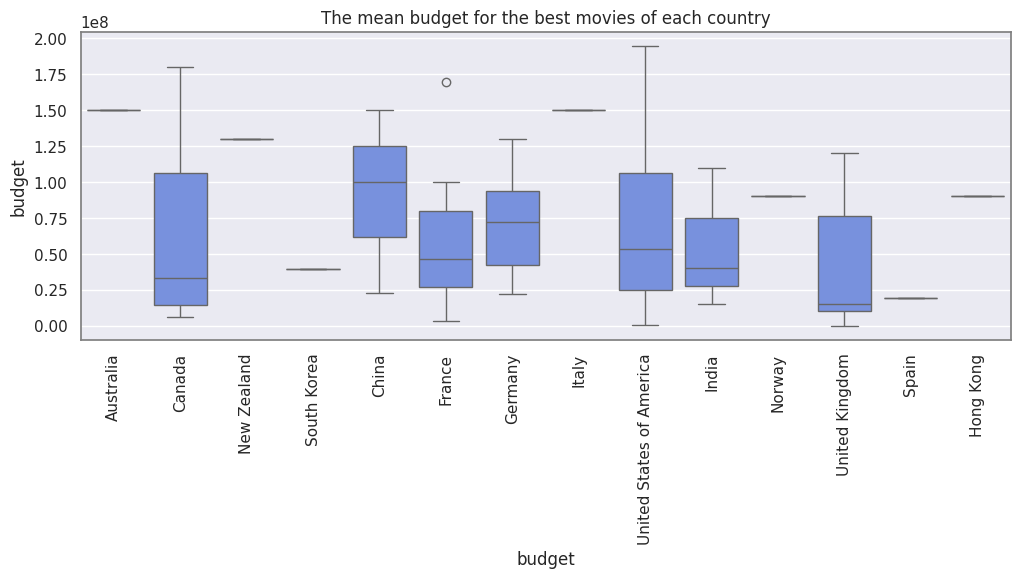

In [ ]:
sns.set_palette("coolwarm")
plt.figure(figsize=(12,4))
sns.boxplot(data=most_watched_movies, x='country', y='budget', order=order)
plt.xticks(rotation=90)
plt.xlabel("budget")
plt.title("The mean budget for the best movies of each country")

Text(0.5, 1.0, 'The mean popularity for the best movies of each country')

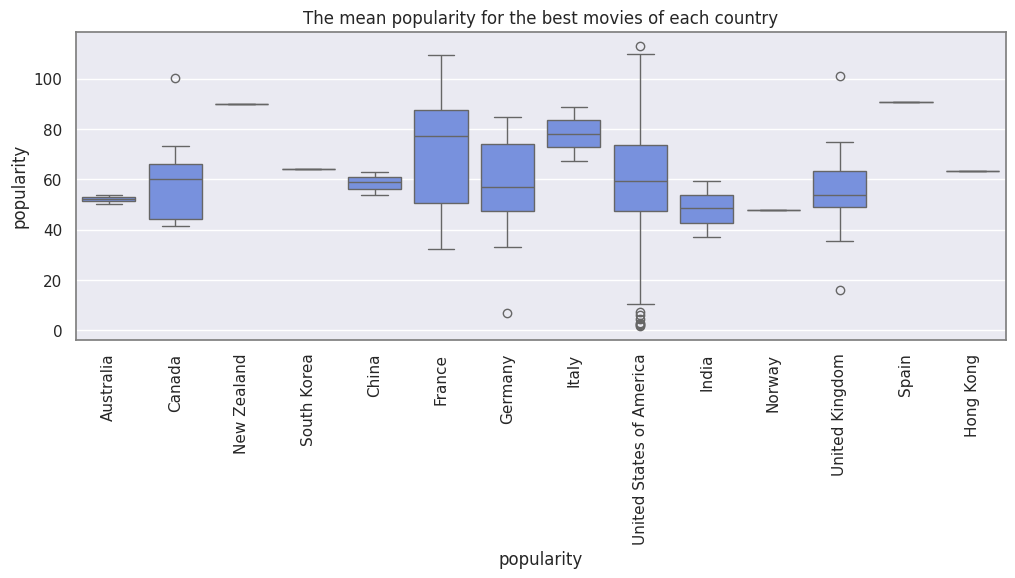

In [ ]:
sns.set_palette("coolwarm")
plt.figure(figsize=(12,4))
sns.boxplot(data=most_watched_movies, x='country', y='popularity', order=order)
plt.xticks(rotation=90)
plt.xlabel("popularity")
plt.title("The mean popularity for the best movies of each country")

In [ ]:
most_watched_movies.head(1)

,budget,plot_keywords,popularity,production_companies,gross,duration,movie_title,vote_average,num_voted_users,country,director_name,actor_1_name,actor_2_name,actor_3_name,release_month,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,categorical_vote_average
39,170000000,artificial intelligence|secret identity|comput...,73.79505,Walt Disney Pictures|LivePlanet|Prana Studios|...,400062763,125.0,TRON: Legacy,6.3,2841,United States of America,Joseph Kosinski,Jeff Bridges,Olivia Wilde,Bruce Boxleitner,second_half,0,0,0,1,0,0,1,Good movies


## Artists Analysis

In [ ]:
df_cleaned.head(1)

,budget,plot_keywords,popularity,production_companies,gross,duration,movie_title,vote_average,num_voted_users,country,director_name,actor_1_name,actor_2_name,actor_3_name,release_month,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure
23,180000000,england|compass|experiment|lordship|uncle|pola...,42.990906,New Line Cinema|Ingenious Film Partners|Depth ...,372234864,113.0,The Golden Compass,5.8,1303,United Kingdom,Chris Weitz,Nicole Kidman,Daniel Craig,Sam Elliott,second_half,0,0,0,0,0,0,1


In [ ]:
df_cleaned['actor_1_name'].value_counts()

Jennifer Aniston      15
Scarlett Johansson    11
Alec Baldwin          11
Brad Pitt             11
Robert De Niro        11
                      ..
Taylor Handley         1
Bérénice Bejo          1
Charlotte Rampling     1
Michael Douglas        1
Brian Herzlinger       1
Name: actor_1_name, Length: 2472, dtype: int64

In [ ]:
most_watched_movies = df_cleaned[df_cleaned['num_voted_users']>2000]
highly_rated = most_watched_movies[most_watched_movies['vote_average']>6.5]
print(len(highly_rated))
highly_rated['actor_1_name'].unique()

In [ ]:
# @title
super_stars = ['Robert De Niro', 'Jack Nicholson', 'Marlon Brando', 'Denzel Washington', 'Katharine Hepburn', 'Humphrey Bogart', 'Meryl Streep', 'Daniel Day-Lewis', 'Sidney Poitier', 'Clark Gable', 'Ingrid Bergman', 'Tom Hanks', 'Elizabeth Taylor', 'Bette Davis', 'Gregory Peck', 'Leonardo DiCaprio', 'Cate Blanchett', 'Audrey Hepburn', 'Spencer Tracy', 'Kate Winslet', 'Shah Rukh Khan', 'Viola Davis', 'Sophia Loren', 'Cary Grant', 'Vivien Leigh', 'Marilyn Monroe', 'Laurence Olivier', 'James Stewart', 'Steve McQueen', 'Diane Keaton', 'Julia Roberts', 'Jodie Foster', 'Judy Garland', 'Morgan Freeman', 'Paul Newman', 'Henry Fonda', 'Catherine Deneuve', 'Grace Kelly', 'Helen Mirren', 'James Cagney', 'Angela Bassett', 'Johnny Depp', 'Greta Garbo', 'Olivia de Havilland', 'Charles Chaplin', 'Setsuko Hara', 'Julie Andrews', 'Montgomery Clift', 'Isabelle Huppert', 'Al Pacino', 'Rita Hayworth', 'Halle Berry', 'James Dean', 'Kirk Douglas', 'Natalie Wood', 'Marcello Mastroianni', 'Joan Crawford', 'Harrison Ford', 'Susan Sarandon', 'Gene Kelly', 'Glenn Close', 'Joan Fontaine', 'Julianne Moore', 'Will Smith', 'Bruce Lee', 'Regina King', 'Angelina Jolie', 'John Wayne', 'Jane Fonda', 'Charlton Heston', 'Gary Cooper', 'Anthony Hopkins', 'Liv Ullmann', 'Natalie Portman', 'Gérard Depardieu', 'Forest Whitaker', 'Sandra Bullock', 'Deborah Kerr', 'Toshirô Mifune', 'Dustin Hoffman', 'Mohanlal', 'Emma Thompson', 'Tom Cruise', 'Michelle Pfeiffer', 'Faye Dunaway', 'Samuel L. Jackson', "Peter O'Toole", 'Heath Ledger', 'Penélope Cruz', 'Nicole Kidman', 'Chadwick Boseman', 'Antonio Banderas', 'Sigourney Weaver', 'Salma Hayek', 'Don Cheadle', 'Frances McDormand', 'Kathy Bates', 'Omar Sharif', 'Amy Adams', 'Joaquin Phoenix', 'Jeff Bridges', 'Ben Kingsley', 'Tommy Lee Jones', 'Robert Redford', 'Jack Lemmon', 'Christopher Plummer', 'George C. Scott', 'Robin Williams', 'Christopher Walken', 'Philip Seymour Hoffman', 'George Clooney', 'Gene Hackman', 'Bruce Willis', 'Sean Connery', 'Ian McKellen', 'Russell Crowe', 'Bill Murray', 'Nicolas Cage', 'Joe Pesci', 'Brad Pitt', 'Kevin Costner', 'Donald Sutherland', 'Clint Eastwood', 'Michael Douglas', 'Robert Downey Jr.', 'Ava Gardner', 'Sally Field', 'Doris Day', 'Shirley MacLaine', 'Holly Hunter', 'Hilary Swank', 'Claudette Colbert', 'Diane Lane', 'Jessica Lange', 'Gloria Swanson', 'Lauren Bacall', 'Lucy Liu', 'Norma Shearer', 'Bette Midler', 'Mary Tyler Moore', 'Anna Magnani', 'Judi Dench', 'Sharon Stone', 'Kim Basinger', 'Glenda Jackson', 'Donna Reed', 'Demi Moore', 'Anne Hathaway', 'Liza Minnelli', 'Geena Davis', 'Peter Sellers', 'Woody Allen', 'Mel Gibson', 'Jim Carrey', 'Mark Wahlberg', 'Steve Martin', 'Javier Bardem', 'Christoph Waltz', 'Tim Robbins', 'Arnold Schwarzenegger', 'Sylvester Stallone', 'Viggo Mortensen', 'Christopher Lee', 'Geoffrey Rush', 'Alec Guinness', 'Richard Burton', 'Alec Baldwin', 'James Caan', 'Chiwetel Ejiofor', 'Mads Mikkelsen', 'Ben Stiller', 'Willem Dafoe', 'Ed Harris', 'Harvey Keitel', 'Jon Voight', 'Drew Barrymore', 'Winona Ryder', 'Kathleen Turner', 'Uma Thurman', 'Rene Russo', 'Whoopi Goldberg', 'Annette Bening', 'Maggie Smith', 'Barbra Streisand', 'Jennifer Lawrence', 'Joanne Woodward', 'Mercedes McCambridge', 'Anjelica Huston', 'Dianne Wiest', 'Goldie Hawn', 'Claudia Cardinale', 'Gwyneth Paltrow', 'Charlize Theron', 'Debra Winger', 'Marion Cotillard', 'Christina Ricci', 'Juliette Binoche', 'Daryl Hannah', 'Shirley Booth', 'Reese Witherspoon', 'Benicio Del Toro', 'Kevin Bacon', 'Patrick Swayze', 'Michael Caine', 'Robert Duvall', 'Burt Lancaster', 'Robert Mitchum', 'Colin Farrell', 'William Holden', 'Edward G. Robinson', 'William Powell', 'Jared Leto', 'Errol Flynn', 'Groucho Marx', 'James Mason', 'Buster Keaton', 'Orson Welles', 'Fred Astaire', 'Bradley Cooper', 'Gary Oldman', 'Jude Law', 'Paul Giamatti', 'Liam Neeson', 'Matt Damon', 'Michael Fassbender', 'Carol Burnett', 'Jessica Tandy', 'Helen Hunt', 'Patricia Arquette', 'Carmen Miranda', 'Kate Hudson', 'Catherine Zeta-Jones', 'Cameron Diaz', 'Debbie Reynolds', 'Ellen Burstyn', "Maureen O'Hara", 'Myrna Loy', 'Lena Headey', 'Toni Collette', 'Laura Linney', 'Marlene Dietrich', 'Carole Lombard', 'Jean Arthur', 'Jean Harlow', 'Ginger Rogers', 'Mary Pickford', 'Mae West', 'Gillian Anderson', 'Emma Watson', 'Meg Ryan', 'Alan Arkin', 'Kurt Russell', 'Jake Gyllenhaal', 'Ryan Gosling', 'Colin Firth', 'Jamie Foxx', 'Adrien Brody', 'Roberto Benigni', 'Jeremy Irons', 'F. Murray Abraham', 'Richard Dreyfuss', 'Peter Finch', 'Art Carney', 'Cliff Robertson', 'Lee Marvin', 'Rex Harrison', 'Anthony Quinn', 'Maximilian Schell', 'Tom Hardy', 'David Niven', 'William Hurt', 'Yul Brynner', 'Ernest Borgnine', 'Benedict Cumberbatch', 'Rod Steiger', 'Chloë Grace Moretz', 'Anna Kendrick', 'Emily Watson', 'Helena Bonham Carter', 'Keira Knightley', 'Alexis Thorpe', 'Marion Davies', 'Scarlett Johansson', 'Dakota Fanning', 'Jennifer Aniston', 'Jennifer Connelly', 'Rachel McAdams', 'Carey Mulligan', 'Mila Kunis', 'Amanda Seyfried', 'Jennifer Lopez', 'Neve Campbell', 'Fairuza Balk', 'Jessica Alba', 'Kristen Stewart', 'Julie Walters', 'Rooney Mara', 'Jamie Lee Curtis', 'Emma Stone', 'Kirsten Dunst', 'José Ferrer', 'Broderick Crawford', 'Ronald Colman', 'Fredric March', 'Ray Milland', 'Bing Crosby', 'Paul Lukas', 'Robert Donat', 'Paul Muni', 'Victor McLaglen', 'Charles Laughton', 'Wallace Beery', 'Lionel Barrymore', 'Jeff Goldblum', 'Chris Hemsworth', 'Warner Baxter', 'Emil Jannings', 'Chris Cooper', 'Jim Broadbent', 'James Coburn', 'Cuba Gooding Jr.', 'Martin Landau', 'Jack Palance', 'Kevin Kline', 'Don Ameche', 'Kate Beckinsale', 'Zooey Deschanel', 'Michelle Williams', 'Milla Jovovich', 'Selena Gomez', 'Rachel Weisz', 'Kristen Bell', 'Katherine Heigl', 'Liv Tyler', 'Jessica Chastain', 'Megan Fox', 'Betty White', 'Geraldine Page', 'Eliza Dushku', 'Robin Wright', 'Leighton Meester', 'Jennifer Jones', 'Shirley Temple', 'Julia Louis-Dreyfus', 'Olivia Thirlby', 'Cher', 'Sissy Spacek', 'Louise Fletcher', 'Julie Christie', 'Patricia Neal', 'Haing S. Ngor', 'Louis Gossett Jr.', 'John Gielgud', 'Timothy Hutton', 'Melvyn Douglas', 'Jason Robards', 'George Burns', 'Christian Bale', 'Ethan Hawke', 'Ben Johnson', 'John Mills', 'Jack Albertson', 'Sean Penn', 'George Kennedy', 'Walter Matthau', 'Martin Balsam', 'Peter Ustinov', 'Ed Begley', 'George Chakiris', 'Hugh Griffith', 'Burl Ives', 'Red Buttons', "Edmond O'Brien", 'Chris Pratt', 'Frank Sinatra', 'Anne Bancroft', 'Kim Novak', 'Simone Signoret', 'Elliot Page', 'Angela Lansbury', 'Judy Holliday', 'Loretta Young', 'Shirley Jones', 'Vera Farmiga', 'Helen Hayes', 'Marie Dressler', 'Janet Gaynor', "Lupita Nyong'o", 'Octavia Spencer', 'Melissa Leo', "Mo'Nique", 'Marlee Matlin', 'Tilda Swinton', 'Jennifer Hudson', 'Renée Zellweger', 'Marcia Gay Harden', 'Anna Paquin', 'Marisa Tomei', 'Mercedes Ruehl', 'Brenda Fricker', 'Jean Reno', 'George Sanders', 'Dean Jagger', 'Walter Huston', 'Edmund Gwenn', 'Harold Russell', 'Hugh Grant', 'Barry Fitzgerald', 'Charles Coburn', 'Van Heflin', 'Donald Crisp', 'Thomas Mitchell', 'Walter Brennan', 'Joseph Schildkraut', 'Keanu Reeves', 'Channing Tatum', 'Hugh Jackman', 'Dwayne Johnson', 'Adam Sandler', 'Daniel Radcliffe', 'Daniel Craig', 'Henry Cavill', 'Vin Diesel', 'Ben Affleck', 'Chris Pine', 'Olympia Dukakis', 'Peggy Ashcroft', 'Linda Hunt', 'Maureen Stapleton', 'Mary Steenburgen', 'Beatrice Straight', 'Vanessa Redgrave', 'Lee Grant', 'Eileen Heckart', 'Cloris Leachman', 'Ruth Gordon', 'Estelle Parsons', 'Sandy Dennis', 'Shelley Winters', 'Maggie Gyllenhaal', 'Katie Holmes', 'Patty Duke', 'Rita Moreno', 'Wendy Hiller', 'Miyoshi Umeki', 'Dorothy Malone', 'Jo Van Fleet', 'Eva Marie Saint', 'Gloria Grahame', 'Kim Hunter', 'Lee J. Cobb', 'Andrew Garfield', 'John Cazale', 'Jeremy Renner', 'Steve Carell', 'Jean Dujardin', 'Chris Evans', 'James Franco', 'Zach Galifianakis', 'Will Ferrell', 'Shia LaBeouf', 'Seth Rogen', 'Joseph Gordon-Levitt', 'Ryan Reynolds', 'Paul Rudd', 'Jason Segel', 'Jason Statham', 'Dick Van Dyke', 'Jesse Eisenberg', 'Owen Wilson', 'Jason Bateman', 'Tyler Perry', 'Liam Hemsworth', 'William Shatner', 'Gene Wilder', 'Thora Birch', 'Claire Trevor', 'Celeste Holm', 'Anne Baxter', 'Queen Latifah', 'Ethel Barrymore', 'Rosario Dawson', 'Teresa Wright', 'Mary Astor', 'Jane Darwell', 'Alicia Vikander', 'Mia Wasikowska', 'Abigail Breslin', 'Gale Sondergaard', 'Melissa McCarthy', 'Tina Fey', 'Zoe Saldana', 'Elisabeth Moss', 'Adrianne Palicki', 'Jennifer Garner', 'Kristen Wiig', 'June Squibb', 'Sally Hawkins', 'Kaley Cuoco', 'Naomi Watts', 'Robert Pattinson', 'Charlie Hunnam', 'Nicholas Hoult', 'Aaron Taylor-Johnson', 'Bryan Cranston', 'Gerard Butler', 'Paul Walker', 'Karl Urban', 'Logan Lerman', 'Dave Franco', 'Tom Hiddleston', 'Peter Dinklage', 'Taylor Kitsch', 'Edward Norton', 'Guy Pearce', 'Mark Ruffalo', 'Mickey Rourke', 'Frank Langella', 'Eddie Redmayne', 'David Strathairn', 'Terrence Howard', 'Ralph Fiennes', 'Tom Wilkinson', 'Richard Farnsworth', 'Nick Nolte', 'AnnaSophia Robb', 'Gemma Arterton', 'Olivia Wilde', 'Isla Fisher', 'Shailene Woodley', 'Rebel Wilson', 'Emma Roberts', 'Amber Heard', 'Teresa Palmer', 'Saoirse Ronan', 'Elizabeth Banks', 'Ida Lupino', 'Natalie Dormer', 'Brittany Snow', 'Kate Mara', 'Julianne Hough', 'Lily Collins', 'Cobie Smulders', 'Alice Eve', 'Jamie Chung', 'Noomi Rapace', 'Blake Lively', 'Maggie Grace', 'Jessica Biel', 'Eva Green', 'Peter Fonda', 'Woody Harrelson', 'Billy Bob Thornton', 'Idris Elba', 'Nigel Hawthorne', 'Laurence Fishburne', 'Stephen Rea', 'Warren Beatty', 'Richard Harris', 'John Cusack', 'Kenneth Branagh', 'Edward James Olmos', 'Max von Sydow', 'Bruce Dern', 'Bob Hoskins', 'James Woods', 'John Hawkes', 'James Garner', 'Sam Waterston', 'Tom Hulce', 'Albert Finney', 'Tom Conti', 'Tom Courtenay', 'Dudley Moore', 'John Hurt', 'Kat Dennings', 'Priyanka Chopra Jonas', 'Emmanuelle Riva', 'Greta Gerwig', 'Brie Larson', 'Jessica Lucas', 'Maria Falconetti', 'Greer Garson', 'Rosalind Russell', 'Raquel Welch', 'Linda Fiorentino', 'Gabourey Sidibe', 'Judy Davis', 'Mia Farrow', 'Audrey Tautou', 'Jeanne Moreau', 'Jane Wyman', 'Gena Rowlands', 'Lesley Manville', 'Elizabeth Olsen', 'Nastassja Kinski', 'Mélanie Laurent', 'Whitney Houston', 'Felicity Huffman', 'Imelda Staunton', 'Oscar Isaac', 'Jon Heder', 'Miles Teller', 'Daniel Brühl', 'James Gandolfini', 'Michael B. Jordan', 'Anthony Perkins', 'David Thewlis', 'Klaus Kinski', 'Malcolm McDowell', 'Ray Winstone', 'Jean-Paul Belmondo', 'Andy Serkis', 'Matthew Broderick', 'Dennis Hopper', 'Michael Rooker', 'Vincent Gallo', 'Kevin Spacey', 'Vincent Cassel', 'J.K. Simmons', 'Boris Karloff', 'Peter Lorre', 'Matthew McConaughey', 'Paddy Considine', 'Ryan Phillippe', 'Kerry Washington', 'Carrie-Anne Moss', 'Janet Leigh', 'Catalina Sandino Moreno', 'Samantha Morton', 'Keisha Castle-Hughes', 'Barbara Stanwyck', 'Joan Allen', 'Janet McTeer', 'Fernanda Montenegro', 'Kristin Scott Thomas', 'Brenda Blethyn', 'Elisabeth Shue', 'Miranda Richardson', 'Stockard Channing', 'Luise Rainer', 'Mary McDonnell', 'Lucille Ball', 'Laura Dern', 'Pauline Collins', 'Isabelle Adjani', 'Melanie Griffith', 'Sally Kirkland', 'Jane Alexander', 'Marsha Mason', 'Freddie Highmore', 'Michael J. Fox', 'John Travolta', 'Chow Yun-Fat', 'Seth MacFarlane', 'Jet Li', 'John Houseman', 'Chuck Norris', 'Jean-Claude Van Damme', 'Sam Rockwell', 'Takashi Shimura', 'Richard E. Grant', 'Leslie Nielsen', 'Simon Pegg', 'John Malkovich', 'Michael Shannon', 'Martin Sheen', 'Christopher Guest', 'Alan Rickman', 'Jackie Earle Haley', 'Gig Young', 'James Spader', 'Eric Bana', 'Romain Duris', 'Robert Shaw', 'Jacki Weaver', 'Bérénice Bejo', 'Hailee Steinfeld', 'Jennifer Jason Leigh', 'Kathleen Quinlan', 'Taraji P. Henson', 'Amy Ryan', 'Ruby Dee', 'Jill Clayburgh', 'Adriana Barraza', 'Rinko Kikuchi', 'Catherine Keener', 'Charlotte Rampling', 'Sophie Okonedo', 'Patricia Clarkson', 'Shohreh Aghdashloo', 'Lindsay Lohan', 'Michelle Trachtenberg', 'Chloë Sevigny', 'Lynn Redgrave', 'Rachel Griffiths', 'Margot Robbie', 'Lili Taylor', 'Robin Weigert', 'Lake Bell', 'Claude Rains', 'Steve Buscemi', 'John Rhys-Davies', 'Jean-Louis Trintignant', 'Joseph Cotten', 'Barry Pepper', 'Erich von Stroheim', 'Patrick Wilson', 'Christopher Lloyd', 'Ben Foster', 'Joel McCrea', 'Choi Min-sik', 'Ewan McGregor', 'Gael García Bernal', 'Bruno Ganz', 'Sean Astin', 'Irrfan Khan', 'Michael C. Hall', 'Roy Scheider', 'Casey Affleck', 'Gary Busey', 'Norman Reedus', 'Jeff Daniels', 'Stanley Tucci', 'Kiefer Sutherland', 'Michelle Yeoh', 'Léa Seydoux', 'Dakota Johnson', 'Julie Delpy', 'Linda Hamilton', 'Carrie Fisher', 'Pam Grier', 'Björk', 'Emily Browning', 'Juliette Lewis', 'Sarah Jessica Parker', 'Piper Laurie', 'Miley Cyrus', 'Lily Tomlin', 'Jane Seymour', 'Gloria Stuart', 'Talia Shire', 'Gal Gadot', 'Sue Lyon', 'Olivia Newton-John', 'Minnie Driver', 'Teri Garr', 'Keri Russell', 'Jean Seberg', 'Sarah Polley', 'Josh Brolin', 'Hal Holbrook', 'Djimon Hounsou', 'Matt Dillon', 'Alan Alda', 'Thomas Haden Church', 'Clive Owen', 'Ken Watanabe', 'Suraj Sharma', 'John C. Reilly', 'Michael Clarke Duncan', 'Haley Joel Osment', 'Greg Kinnear', 'Burt Reynolds', 'Robert Forster', 'Jason Schwartzman', 'William H. Macy', 'Armin Mueller-Stahl', 'Tim Roth', 'James Cromwell', 'Chazz Palminteri', 'Gary Sinise', 'Paul Scofield', 'Pete Postlethwaite', 'Hugo Weaving', 'Jada Pinkett Smith', "Tatum O'Neal", 'Anna Faris', 'Hattie McDaniel', 'Famke Janssen', 'Rosamund Pike', 'Bonnie Hunt', 'Leslie Mann', 'Mindy Kaling', 'Thandiwe Newton', 'Amy Poehler', 'Amanda Peet', 'Julia Stiles', 'Maria Bello', 'Eva Mendes', 'Emily Blunt', 'Rose Byrne', 'Ashley Judd', 'Emilia Clarke', 'Christina Applegate', 'Nia Long', 'Felicity Jones', 'Téa Leoni', 'Alexandra Daddario', 'Jena Malone', 'Richard Gere', 'Nick Frost', 'Ray Liotta', 'Chris Rock', 'Jon Hamm', 'Neil Patrick Harris', 'Charlie Sheen', 'Mark Rylance', 'Andy Garcia', 'Michael Lerner', 'Graham Greene', 'Bruce Davison', 'Dan Aykroyd', 'Danny Aiello', 'River Phoenix', 'Dean Stockwell', 'Billy Crystal', 'John Goodman', 'Orlando Bloom', 'Stellan Skarsgård', 'Alexander Skarsgård', 'Mike Myers', 'Tyrese Gibson', 'Elijah Wood', 'Danny DeVito', 'Susan Hayward', 'Michelle Rodriguez', 'Sarah Michelle Gellar', 'Sandra Oh', 'Margot Kidder', 'Beyoncé', 'Rebecca Hall', 'Piper Perabo', 'Courteney Cox', 'Parker Posey', 'Paula Patton', 'Michelle Monaghan', 'Claire Danes', 'Allison Janney', 'Kate Bosworth', 'Evan Rachel Wood', 'Mira Sorvino', 'Ziyi Zhang', 'Amanda Bynes', 'Lisa Kudrow', 'Brit Marling', 'Cynthia Erivo', 'Sofía Vergara', 'Mandy Moore', 'Virginia Madsen', 'James Marsden', 'Tim Allen', 'Giovanni Ribisi', 'Rutger Hauer', 'Vince Vaughn', 'Brian Cox', 'Dennis Quaid', 'John Leguizamo', 'Michael Keaton', 'Billy Burke', 'Brendan Gleeson', 'Charles Bronson', 'Jonathan Pryce', 'Tobey Maguire', 'Michael Sheen', 'Justin Long', 'Jack Black', 'Mel Brooks', 'Pierce Brosnan', 'Sean Bean', 'Mahershala Ali', 'Josh Duhamel', 'Eddie Murphy', 'Jon Favreau', 'Danny Glover', 'Freida Pinto', 'Hilary Duff', 'Mary Elizabeth Winstead', 'Jennifer Coolidge', 'Andrea Riseborough', 'Molly Ringwald', 'January Jones', 'Maya Rudolph', 'Sophie Marceau', 'Franka Potente', 'Claire Foy', 'Rashida Jones', 'Alicia Silverstone', 'Lillian Gish', 'Evangeline Lilly', 'Olivia Colman', 'Mireille Enos', 'Jennifer Love Hewitt', 'Emmy Rossum', 'Joey King', 'Ginnifer Goodwin', 'Christine Taylor', 'Vanessa Hudgens', 'Abbie Cornish', 'Florence Pugh', 'Ian Holm', 'Nathan Lane', 'Cary Elwes', 'Martin Lawrence', 'Steve Coogan', 'Sacha Baron Cohen', 'Jeffrey Wright', 'Jackie Chan', 'Aaron Eckhart', 'Sam Worthington', 'Jack Davenport', 'Alfred Molina', 'Tim Curry', 'Mark Hamill', 'Brendan Fraser', 'Ice Cube', 'Liev Schreiber', 'Ed Helms', 'Val Kilmer', 'Russell Brand', 'Craig T. Nelson', 'Bernie Mac', 'Patrick Stewart', 'Seth Green', 'Ashton Kutcher', 'Randy Quaid', 'Wesley Snipes', 'David Oyelowo', 'Mark Strong', 'Rob Schneider', 'Jay Baruchel', 'Hayden Christensen', 'Ray Stevenson', 'Paul Bettany', 'Hugh Laurie', 'Chris Tucker', 'John Candy', 'Richard Attenborough', "Chris O'Donnell", 'Benjamin Bratt', 'Common', 'Marlon Wayans', 'Albert Brooks', 'Aaron Paul', 'Macaulay Culkin', 'Sam Elliott', 'Taron Egerton', 'Jim Caviezel', 'Elvis Presley', 'Jonah Hill', 'Sung Kang', 'Jason Sudeikis', 'Josh Hartnett', 'Cillian Murphy', 'Billy Crudup', 'Anthony Mackie', 'John Barrymore', 'Timothy Olyphant', 'Josh Gad', 'Billy Zane', 'Luke Wilson', 'Peter Sarsgaard', 'Rhys Ifans', 'Topher Grace', 'Kevin Hart', 'Paul Dano', 'Bill Hader', 'Rob Lowe', 'Mel Blanc', 'David Spade', 'Rob Riggle', 'Lance Henriksen', 'Richard Jenkins', 'Emilio Estevez', 'Michael Ealy', 'Jamie Bell', 'Troy Baker', 'Danny McBride', 'Jonathan Rhys Meyers', 'Michael Cera', 'Bill Paxton', 'Ioan Gruffudd', 'Andrew Lincoln', 'Ezra Miller', 'Bill Pullman', 'Craig Robinson', 'Charlie Day', 'Andy Samberg', 'Garrett Hedlund', 'Cam Gigandet', 'John Krasinski', 'Kevin James', 'Christopher Reeve', 'James McAvoy', 'Rufus Sewell', 'Adam Driver', 'Ned Beatty', 'John Cleese', 'John Turturro', 'Jerry Lewis']

In [ ]:
len(super_stars)

1000

In [ ]:
def superstar_count(*input_list):
  count = 0
  for el in input_list:
    if el in super_stars:
      count += 1
  return count

In [ ]:
df_cleaned['super_stars'] = df_cleaned[['actor_1_name', 'actor_2_name', 'actor_3_name']].apply(lambda x: superstar_count(*x), axis=1)
df_cleaned['super_stars'].value_counts()

0    1584
1    1230
2     942
3     512
Name: super_stars, dtype: int64

Text(0.5, 1.0, 'The budget of the movies based on the number of super stars')

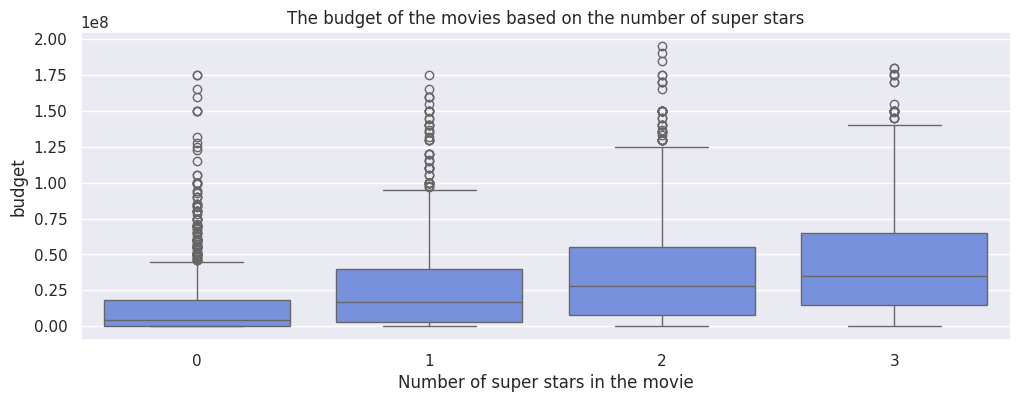

In [ ]:
sns.set_palette("coolwarm")
plt.figure(figsize=(12,4))
sns.boxplot(data=df_cleaned, x='super_stars', y='budget')
plt.xlabel("Number of super stars in the movie")
plt.title("The budget of the movies based on the number of super stars")

Text(0.5, 1.0, 'The popularity of the movies based on the number of super stars')

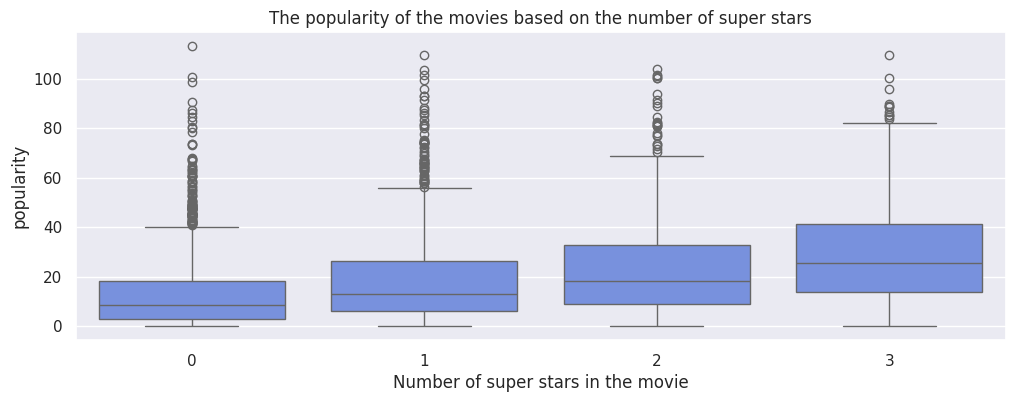

In [ ]:
sns.set_palette("coolwarm")
plt.figure(figsize=(12,4))
sns.boxplot(data=df_cleaned, x='super_stars', y='popularity')
plt.xlabel("Number of super stars in the movie")
plt.title("The popularity of the movies based on the number of super stars")

Text(0.5, 1.0, 'The gross of the movies based on the number of super stars')

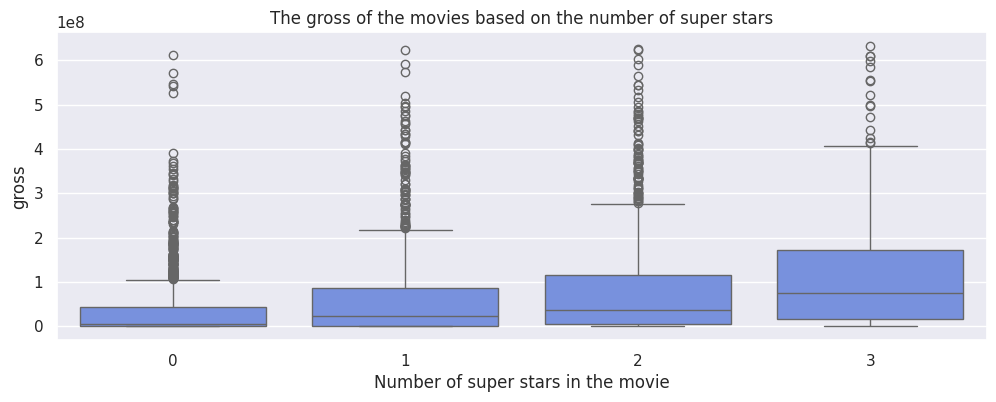

In [ ]:
sns.set_palette("coolwarm")
plt.figure(figsize=(12,4))
sns.boxplot(data=df_cleaned, x='super_stars', y='gross')
plt.xlabel("Number of super stars in the movie")
plt.title("The gross of the movies based on the number of super stars")

Text(0.5, 1.0, 'The averaged vote of the movies based on the number of super stars')

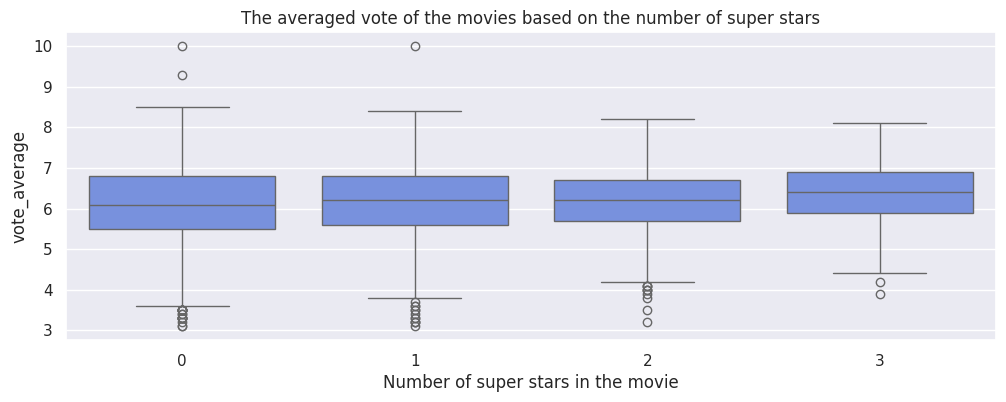

In [ ]:
sns.set_palette("coolwarm")
plt.figure(figsize=(12,4))
sns.boxplot(data=df_cleaned, x='super_stars', y='vote_average')
plt.xlabel("Number of super stars in the movie")
plt.title("The averaged vote of the movies based on the number of super stars")

Text(0.5, 1.0, 'The number of the users voted to the movies based on the number of super stars')

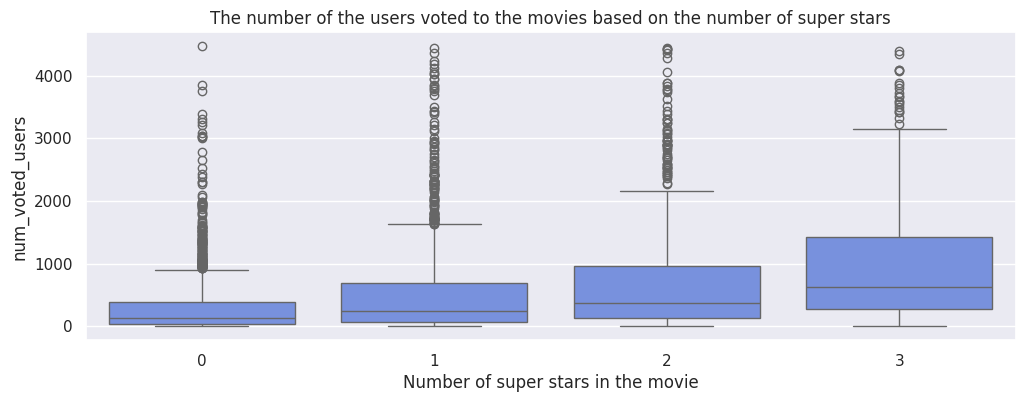

In [ ]:
sns.set_palette("coolwarm")
plt.figure(figsize=(12,4))
sns.boxplot(data=df_cleaned, x='super_stars', y='num_voted_users')
plt.xlabel("Number of super stars in the movie")
plt.title("The number of the users voted to the movies based on the number of super stars")

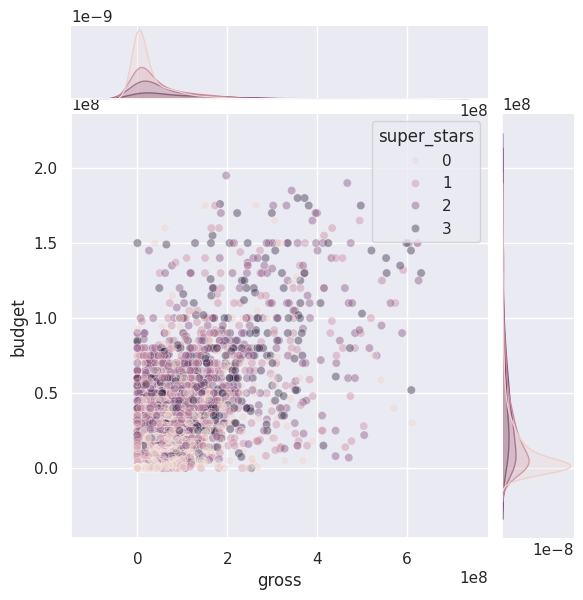

In [ ]:
sns.jointplot(data=df_cleaned, x='gross', y='budget', alpha=.4, hue='super_stars')

In [ ]:
df_cleaned.head(1)

,budget,plot_keywords,popularity,production_companies,gross,duration,movie_title,vote_average,num_voted_users,country,director_name,actor_1_name,actor_2_name,actor_3_name,release_month,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,super_stars
23,180000000,england|compass|experiment|lordship|uncle|pola...,42.990906,New Line Cinema|Ingenious Film Partners|Depth ...,372234864,113.0,The Golden Compass,5.8,1303,United Kingdom,Chris Weitz,Nicole Kidman,Daniel Craig,Sam Elliott,second_half,0,0,0,0,0,0,1,3


## 5-2- Genres Analysis <br>
For genres analysis, first of all we construct a dataframe consists of relative columns out of the cleaned dataframe. Then we will go through these steps:
1. removing rows with empty string genres
2. Identify all unique genres exsisting in the dataset
3. Generate dummy columns for each specific genre to making analysis more easier
4. For each specific target columns for analysing different genres success, we will proceed these steps:

  *   Removing the column outliers if there are any
  *   Generate a new dataframe (for example genres_popularities) including one column for each specific genre in which we store the target metric (for example the popularity)
  * Finally we analyse different genres success with analysing boxplot of this newly created dataframe

The target columns which we have considered as a metric for succes are vote_average, num_voted_users and popularity.




In [ ]:
#_____________________________________________
# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

#### **5-2-1. removing rows with empty string genres**

In [ ]:
df_genre = df_cleaned[['budget',
                       'genres',
                       'popularity',
                       'production_companies',
                       'production_countries',
                       'vote_average',
                       'num_voted_users']].copy()
# Replace empty strings with nan
df_genre['genres'] = df_genre['genres'].apply(lambda x: np.nan if x=='' else x)
df_genre['genres'].isnull().sum()

3

In [ ]:
df_genre.dropna(inplace=True)

#### **5-2-2. Identify all unique genres exsisting in the dataset**

In [ ]:
genre_labels = set()
for s in df_genre['genres'].values:
  if not pd.isnull(s):
    s = s.split('|')
    genre_labels = genre_labels.union(set(s))

In [ ]:
genre_labels

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western'}

#### **5-2-3. Generate dummy columns for each specific genre**

In [ ]:
def generate_categorical_columns(df: pd.DataFrame,
                                 ref_col: str,
                                 col_name: str,
                                 keyword: str) -> pd.DataFrame:
  """
  Generates new categorical columns for each distinct categories
  in a complex column like genre in which there are plenty of
  categories dixtinguished by | or some other signs
  """
  df[col_name] = df[ref_col].apply(lambda x: 1 if keyword in x else 0)
  return df

In [ ]:
for genre in genre_labels:
  col_name = 'genre_' + genre.replace(' ', '_')
  df_genre = generate_categorical_columns(df=df_genre,
                                        ref_col='genres',
                                        col_name=col_name,
                                        keyword=genre)
df_genre

,budget,genres,popularity,production_companies,production_countries,vote_average,num_voted_users,genre_History,genre_Comedy,genre_Thriller,genre_Mystery,genre_Western,genre_Horror,genre_Fantasy,genre_Family,genre_Action,genre_Documentary,genre_Romance,genre_Adventure,genre_Foreign,genre_Crime,genre_Animation,genre_War,genre_TV_Movie,genre_Drama,genre_Music,genre_Science_Fiction
0,237000000,Action|Adventure|Fantasy|Science Fiction,150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",7.2,11800,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1
1,300000000,Adventure|Fantasy|Action,139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",6.9,4500,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
2,245000000,Action|Adventure|Crime,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",6.3,4466,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
3,250000000,Action|Crime|Drama|Thriller,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",7.6,9106,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4,260000000,Action|Adventure|Science Fiction,43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",6.1,2124,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,0,Drama,0.918116,"[{'name': 'Asylum Films', 'id': 10571}, {'name...","[{'iso_3166_1': 'US', 'name': 'United States o...",6.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4796,7000,Science Fiction|Drama|Thriller,23.307949,"[{'name': 'Thinkfilm', 'id': 446}]","[{'iso_3166_1': 'US', 'name': 'United States o...",6.9,658,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4798,220000,Action|Crime|Thriller,14.269792,"[{'name': 'Columbia Pictures', 'id': 5}]","[{'iso_3166_1': 'MX', 'name': 'Mexico'}, {'iso...",6.6,238,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4800,0,Comedy|Drama|Romance|TV Movie,1.444476,"[{'name': 'Front Street Pictures', 'id': 3958}...","[{'iso_3166_1': 'US', 'name': 'United States o...",7.0,6,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0


In [ ]:
df_genre.drop('genres', axis=1, inplace=True)

#### **5-2-4. Analyze different success metrics individually**

##### **5-2-4.a. Popularity**

In [ ]:
df_genre_popularity = df_genre.copy()
df_genre_popularity = remove_outliers(df_genre_popularity, 'popularity', .99)

In [ ]:
# Generate a new dataframe named genres_popularities including one column for each specific genre
# in which we store the popularity metric

genres_popularities = pd.DataFrame(index = np.arange(len(df_genre_popularity)))
for genre in genre_labels:
  col_name = 'genre_' + genre.replace(' ', '_')
  series = df_genre_popularity[df_genre_popularity[col_name]==1]['popularity']
  series.index = np.arange(len(series))
  genres_popularities[col_name] = series
genres_popularities.dropna(axis = 0, how = 'all', inplace=True)
genres_popularities

,genre_Horror,genre_Comedy,genre_Romance,genre_TV_Movie,genre_Foreign,genre_History,genre_Action,genre_Music,genre_Western,genre_Adventure,genre_Family,genre_Thriller,genre_Crime,genre_Fantasy,genre_War,genre_Drama,genre_Science_Fiction,genre_Mystery,genre_Animation,genre_Documentary
0,81.834855,52.035179,100.025899,0.812776,0.494460,34.206690,107.376788,62.479574,49.046956,107.376788,48.681969,112.312950,107.376788,115.699814,34.206690,112.312950,43.926995,60.269279,48.681969,10.706613
1,9.476999,49.986590,61.196071,0.102003,0.165367,39.019229,112.312950,5.159407,40.748915,43.926995,98.885637,107.928811,112.312950,98.885637,39.019229,61.226010,57.925623,78.144395,89.186492,15.798622
2,70.867401,59.995418,62.169881,16.536374,0.700127,52.341226,43.926995,23.473004,100.635882,115.699814,53.978602,100.025899,107.928811,57.925623,66.803149,100.025899,99.398009,67.447636,49.986590,20.991740
3,21.214571,22.571780,110.620647,1.923514,0.120820,18.714197,115.699814,14.530946,29.913530,98.885637,78.530105,64.928382,22.571780,99.398009,52.341226,81.834855,52.035179,64.798873,59.995418,10.500980
4,46.834704,92.201962,2.418535,20.466433,2.131524,23.657284,57.925623,9.357734,82.121691,57.925623,89.186492,93.004993,90.237920,53.978602,18.714197,61.196071,64.928382,21.605568,51.692953,0.335195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.464566,NaN,NaN,NaN,NaN
2168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.193779,NaN,NaN,NaN,NaN
2169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.918116,NaN,NaN,NaN,NaN
2170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.307949,NaN,NaN,NaN,NaN


In [ ]:
df_genre_popularity = df_genre.copy()
df_genre_popularity = remove_outliers(df_genre_popularity, 'popularity', .99)
df_genre_popularity = remove_outliers(df_genre_popularity, 'budget', .99)


In [ ]:
# Generate a new dataframe named genres_popularities including one column for each specific genre
# in which we store the popularity metric

# genres_popularities = pd.DataFrame(index = np.arange(len(df_genre_popularity)))
genres_df = dict()
for genre in genre_labels:
  col_name = 'genre_' + genre.replace(' ', '_')
  series = df_genre_popularity[df_genre_popularity[col_name]==1][['popularity', 'budget']]
  series.index = np.arange(len(series))
  genres_df[col_name] = series
  # break
#   genres_popularities[col_name] = series
# genres_popularities.dropna(axis = 0, how = 'all', inplace=True)
genres_df

{'genre_History':      popularity     budget
 0     34.206690  140000000
 1     39.019229  155000000
 2     52.341226  140000000
 3     18.714197  115000000
 4     23.657284  110000000
 ..          ...        ...
 189    3.851000    1000000
 190    6.003418     780000
 191    3.409764     600000
 192    7.330691          0
 193    3.284903     160000
 
 [194 rows x 2 columns],
 'genre_Comedy':       popularity     budget
 0      22.571780  140000000
 1      92.201962  175000000
 2      40.748915  170000000
 3      27.082182  175000000
 4      44.041186  165000000
 ...          ...        ...
 1626    0.048948      22000
 1627    0.674570          0
 1628    4.553644      12000
 1629    0.166513          0
 1630    1.444476          0
 
 [1631 rows x 2 columns],
 'genre_Thriller':       popularity     budget
 0      22.571780  140000000
 1      32.852443  175000000
 2       6.909942   38000000
 3      60.269279  150000000
 4      21.133748  160000000
 ...          ...        ...
 1224  

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'genre_Horror'),
  Text(1, 0, 'genre_Comedy'),
  Text(2, 0, 'genre_Romance'),
  Text(3, 0, 'genre_TV_Movie'),
  Text(4, 0, 'genre_Foreign'),
  Text(5, 0, 'genre_History'),
  Text(6, 0, 'genre_Action'),
  Text(7, 0, 'genre_Music'),
  Text(8, 0, 'genre_Western'),
  Text(9, 0, 'genre_Adventure'),
  Text(10, 0, 'genre_Family'),
  Text(11, 0, 'genre_Thriller'),
  Text(12, 0, 'genre_Crime'),
  Text(13, 0, 'genre_Fantasy'),
  Text(14, 0, 'genre_War'),
  Text(15, 0, 'genre_Drama'),
  Text(16, 0, 'genre_Science_Fiction'),
  Text(17, 0, 'genre_Mystery'),
  Text(18, 0, 'genre_Animation'),
  Text(19, 0, 'genre_Documentary')])

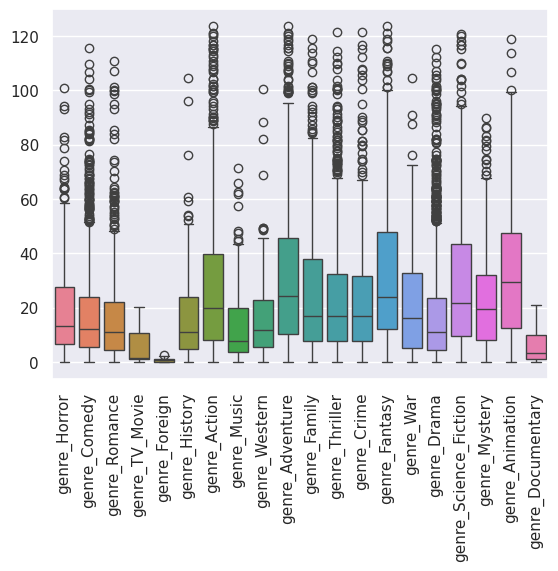

In [ ]:
#  Analysing boxplot of this newly created dataframe
# for assess different genres success

sns.set_palette("mako")
sns.boxplot(data=genres_popularities)
plt.xticks(rotation=90)

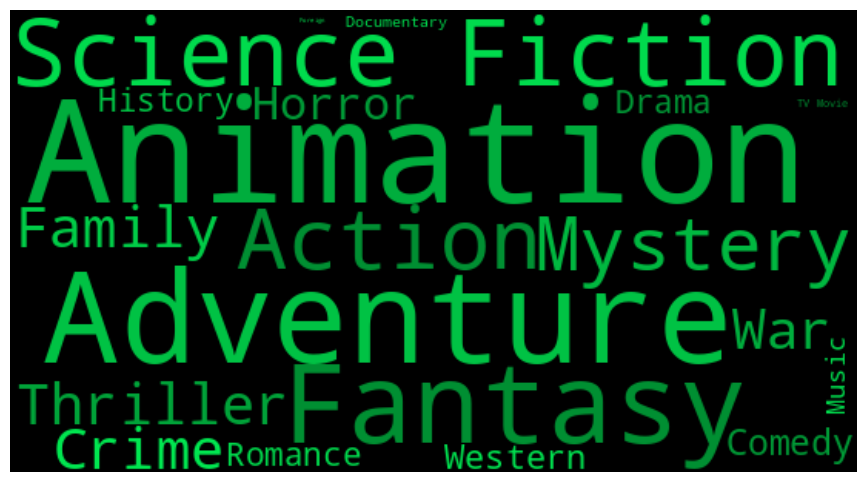

In [ ]:
words = dict()
for genre in genre_labels:
  col_name = 'genre_' + genre.replace(' ', '_')
  words[genre] = genres_popularities[col_name].median()
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black',
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

##### **5-2-4.b. Vote Average**

<Axes: >

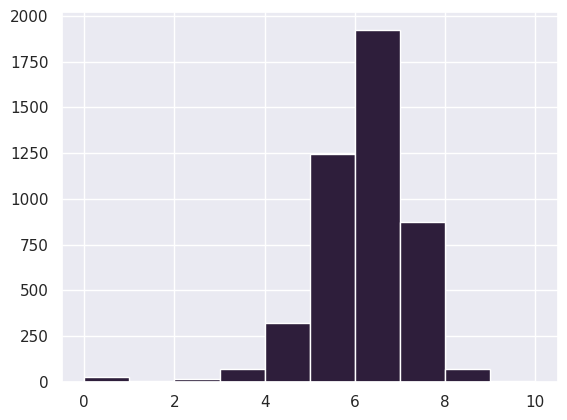

In [ ]:
df_genre['vote_average'].hist()

In [ ]:
df_genre_vote_average = df_genre.copy()
df_genre_vote_average = remove_outliers(df_genre_vote_average, 'vote_average', .01)

In [ ]:
# Generate a new dataframe named genres_vote_average including one column for each specific genre
# in which we store the vote_average metric

genres_vote_average = pd.DataFrame(index = np.arange(len(df_genre_vote_average)))
for genre in genre_labels:
  col_name = 'genre_' + genre.replace(' ', '_')
  series = df_genre_vote_average[df_genre_vote_average[col_name]==1]['vote_average']
  series.index = np.arange(len(series))
  genres_vote_average[col_name] = series
genres_vote_average.dropna(axis = 0, how = 'all', inplace=True)
genres_vote_average

,genre_Horror,genre_Comedy,genre_Romance,genre_TV_Movie,genre_Foreign,genre_History,genre_Action,genre_Music,genre_Western,genre_Adventure,genre_Family,genre_Thriller,genre_Crime,genre_Fantasy,genre_War,genre_Drama,genre_Science_Fiction,genre_Mystery,genre_Animation,genre_Documentary
0,6.7,6.2,7.5,4.9,5.7,6.6,7.2,6.7,5.9,7.2,7.4,7.6,6.3,7.2,6.6,7.6,7.2,6.2,7.4,7.3
1,6.5,5.8,7.3,5.0,4.5,5.6,6.9,7.3,5.1,6.9,7.4,6.1,7.6,6.9,5.6,6.6,6.1,8.1,7.0,6.7
2,6.9,7.6,6.2,6.1,7.3,7.3,6.3,5.4,7.3,6.3,6.3,7.5,6.1,5.9,6.9,7.5,7.3,7.3,5.8,6.4
3,5.5,6.7,7.0,5.2,5.2,5.8,7.6,7.0,6.6,6.1,6.4,5.5,6.1,7.4,7.3,6.7,5.4,7.4,7.6,7.0
4,5.2,6.1,4.8,3.8,6.4,6.8,6.1,5.1,7.8,5.9,7.0,6.5,8.2,5.7,5.8,7.3,6.5,6.5,6.6,6.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.7,NaN,NaN,NaN,NaN
2166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.6,NaN,NaN,NaN,NaN
2167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN
2168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9,NaN,NaN,NaN,NaN


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'genre_Horror'),
  Text(1, 0, 'genre_Comedy'),
  Text(2, 0, 'genre_Romance'),
  Text(3, 0, 'genre_TV_Movie'),
  Text(4, 0, 'genre_Foreign'),
  Text(5, 0, 'genre_History'),
  Text(6, 0, 'genre_Action'),
  Text(7, 0, 'genre_Music'),
  Text(8, 0, 'genre_Western'),
  Text(9, 0, 'genre_Adventure'),
  Text(10, 0, 'genre_Family'),
  Text(11, 0, 'genre_Thriller'),
  Text(12, 0, 'genre_Crime'),
  Text(13, 0, 'genre_Fantasy'),
  Text(14, 0, 'genre_War'),
  Text(15, 0, 'genre_Drama'),
  Text(16, 0, 'genre_Science_Fiction'),
  Text(17, 0, 'genre_Mystery'),
  Text(18, 0, 'genre_Animation'),
  Text(19, 0, 'genre_Documentary')])

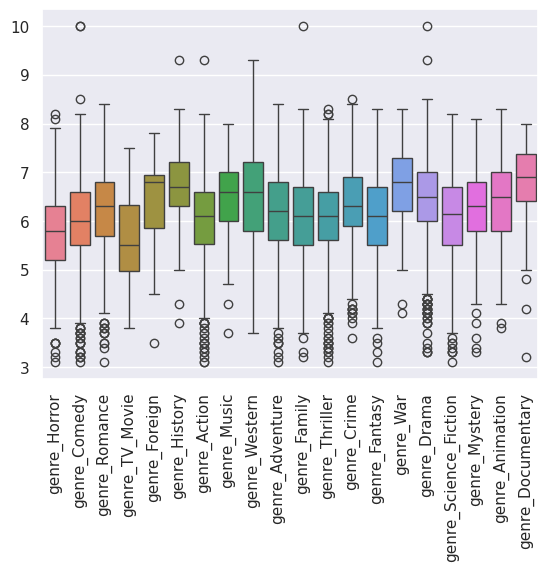

In [ ]:
#  Analysing boxplot of this newly created dataframe
# for assess different genres success

sns.set_palette("mako")
sns.boxplot(data=genres_vote_average)
plt.xticks(rotation=90)

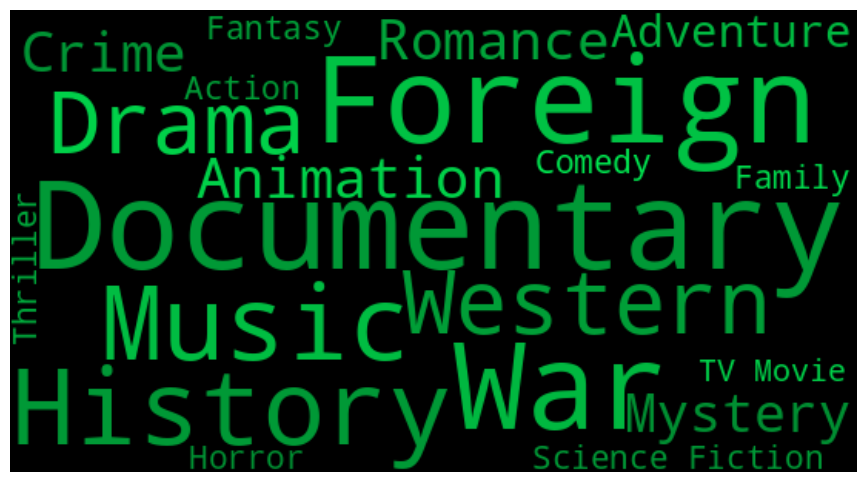

In [ ]:
words = dict()
for genre in genre_labels:
  col_name = 'genre_' + genre.replace(' ', '_')
  words[genre] = genres_vote_average[col_name].median()
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black',
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

##### **5-2-4.c. Number of voted users**

<Axes: >

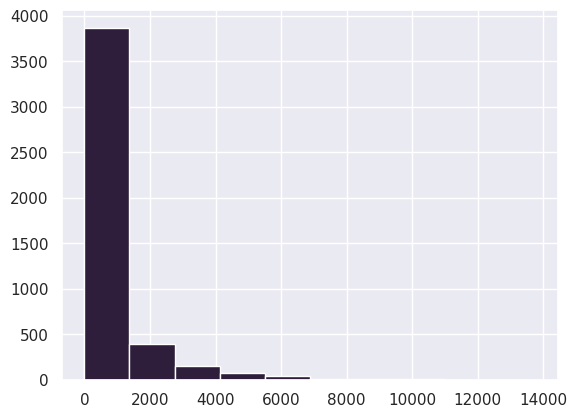

In [ ]:
df_genre['num_voted_users'].hist()

In [ ]:
df_genre_num_voted_users = df_genre.copy()
df_genre_num_voted_users = remove_outliers(df_genre_num_voted_users, 'num_voted_users', .99)

In [ ]:
# Generate a new dataframe named genres_num_voted_users including one column for each specific genre
# in which we store the popularity metric

genres_num_voted_users = pd.DataFrame(index = np.arange(len(df_genre_num_voted_users)))
for genre in genre_labels:
  col_name = 'genre_' + genre.replace(' ', '_')
  series = df_genre_num_voted_users[df_genre_num_voted_users[col_name]==1]['num_voted_users']
  series.index = np.arange(len(series))
  genres_num_voted_users[col_name] = series
genres_num_voted_users.dropna(axis = 0, how = 'all', inplace=True)
genres_num_voted_users

,genre_Horror,genre_Comedy,genre_Romance,genre_TV_Movie,genre_Foreign,genre_History,genre_Action,genre_Music,genre_Western,genre_Adventure,genre_Family,genre_Thriller,genre_Crime,genre_Fantasy,genre_War,genre_Drama,genre_Science_Fiction,genre_Mystery,genre_Animation,genre_Documentary
0,5560.0,4160.0,3769.0,8.0,20.0,1791.0,4500.0,1247.0,2311.0,4500.0,3330.0,2965.0,4466.0,4500.0,1791.0,2337.0,2124.0,2846.0,3330.0,111.0
1,143.0,2033.0,2317.0,3.0,2.0,927.0,4466.0,85.0,1020.0,4466.0,5293.0,2114.0,2965.0,3576.0,927.0,5560.0,1400.0,3292.0,3528.0,247.0
2,4853.0,4597.0,4496.0,1000.0,6.0,1895.0,2124.0,484.0,2051.0,2124.0,1630.0,3525.0,783.0,5293.0,2759.0,3769.0,4160.0,5494.0,2033.0,428.0
3,549.0,4641.0,34.0,20.0,29.0,341.0,3576.0,292.0,106.0,3576.0,4645.0,2487.0,3428.0,1400.0,1895.0,1095.0,2114.0,2129.0,4597.0,167.0
4,1712.0,783.0,3292.0,476.0,6.0,1099.0,1400.0,165.0,831.0,5293.0,3528.0,2463.0,767.0,5246.0,341.0,2141.0,3525.0,2811.0,1736.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN
2170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN
2171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,658.0,NaN,NaN,NaN,NaN


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'genre_Horror'),
  Text(1, 0, 'genre_Comedy'),
  Text(2, 0, 'genre_Romance'),
  Text(3, 0, 'genre_TV_Movie'),
  Text(4, 0, 'genre_Foreign'),
  Text(5, 0, 'genre_History'),
  Text(6, 0, 'genre_Action'),
  Text(7, 0, 'genre_Music'),
  Text(8, 0, 'genre_Western'),
  Text(9, 0, 'genre_Adventure'),
  Text(10, 0, 'genre_Family'),
  Text(11, 0, 'genre_Thriller'),
  Text(12, 0, 'genre_Crime'),
  Text(13, 0, 'genre_Fantasy'),
  Text(14, 0, 'genre_War'),
  Text(15, 0, 'genre_Drama'),
  Text(16, 0, 'genre_Science_Fiction'),
  Text(17, 0, 'genre_Mystery'),
  Text(18, 0, 'genre_Animation'),
  Text(19, 0, 'genre_Documentary')])

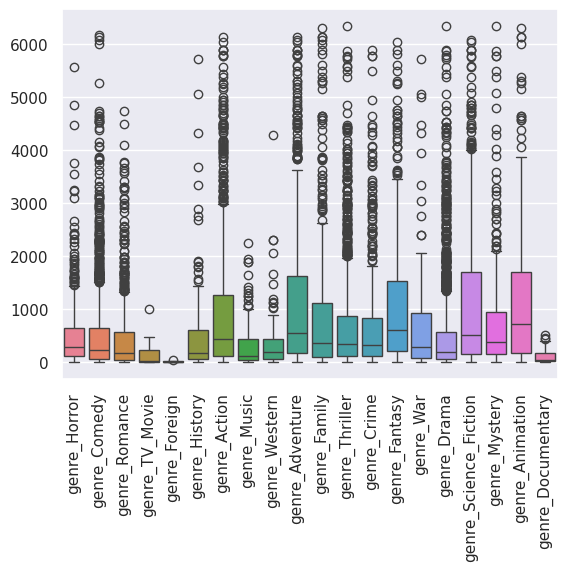

In [ ]:
#  Analysing boxplot of this newly created dataframe
# for assess different genres success

sns.set_palette("mako")
sns.boxplot(data=genres_num_voted_users)
plt.xticks(rotation=90)

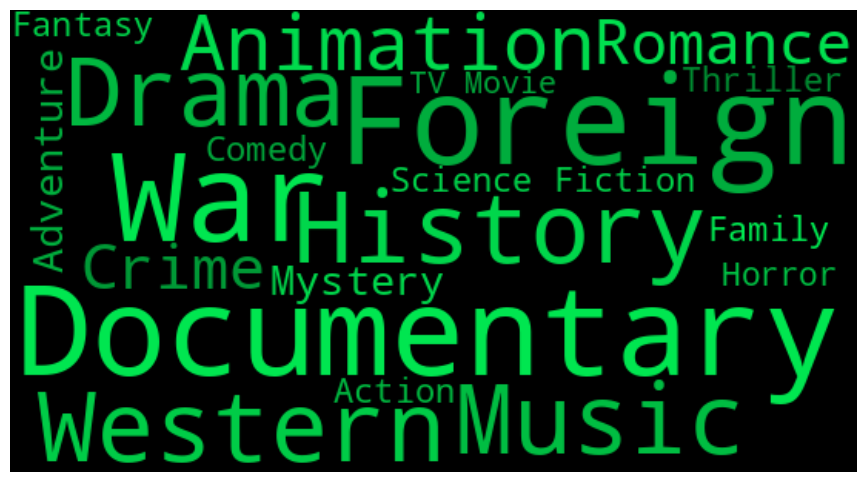

In [ ]:
words = dict()
for genre in genre_labels:
  col_name = 'genre_' + genre.replace(' ', '_')
  words[genre] = genres_vote_average[col_name].median()
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black',
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()